In [2]:
# Dependencies
import os
import sys
from pathlib import Path
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import scipy.stats as st
from uszipcode import SearchEngine
from scipy.stats import linregress

%matplotlib inline 

# Import the API key
from config import geoapify_key
from config import census_key

/Users/natalia/anaconda3/envs/intro_python_requirements_osx/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Brewery data cleanup (Vicky)

The first set of data was obtained from the OpenBreweryAPI. The API is free, however it limits the number of queries to 200 rows and restricts sourcing of data to 2 pages at a time. To load all necessary data, it was necessary to create a loop to move through all 156 pages of the API and collect 100 cases per page or 200 every two pages for the United_States location. 

Through out the document, our team used multiple APIs with large number of rows, and so for the ease of use each dataframe used later was also as saved a csv allowing easy data retrieval for each block of code.

In [2]:
# URL for GET requests to retrieve brewery data
base_url = 'https://api.openbrewerydb.org/v1/breweries?by_country=United_States'

# Define an empty list to fetch the page data for each set of data
brewery_data = []

# Loop through the pages to get all the data
for page in range(1, 156):
    query_url = base_url + "&page="+ str(page) + "&per_page=200"
    response = requests.get(query_url).json()
    brewery_data.append(response)

# Create a list of all the breweries
breweries = []
for page in brewery_data:
    for brewery in page:
        breweries.append(brewery)

# Create a dataframe from the list of breweries
breweries_df = pd.DataFrame(breweries)

breweries_df.head()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
0,5128df48-79fc-4f0f-8b52-d06be54d0cec,(405) Brewing Co,micro,1716 Topeka St,None,None,Norman,Oklahoma,73069-8224,United States,-97.46818222,35.25738891,4058160490,http://www.405brewing.com,Oklahoma,1716 Topeka St
1,9c5a66c8-cc13-416f-a5d9-0a769c87d318,(512) Brewing Co,micro,407 Radam Ln Ste F200,None,None,Austin,Texas,78745-1197,United States,None,None,5129211545,http://www.512brewing.com,Texas,407 Radam Ln Ste F200
2,ef970757-fe42-416f-931d-722451f1f59c,10 Barrel Brewing Co,large,1501 E St,None,None,San Diego,California,92101-6618,United States,-117.129593,32.714813,6195782311,http://10barrel.com,California,1501 E St
3,6d14b220-8926-4521-8d19-b98a2d6ec3db,10 Barrel Brewing Co,large,62970 18th St,None,None,Bend,Oregon,97701-9847,United States,-121.281706,44.08683531,5415851007,http://www.10barrel.com,Oregon,62970 18th St
4,e2e78bd8-80ff-4a61-a65c-3bfbd9d76ce2,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,None,None,Bend,Oregon,97703-2465,United States,-121.3288021,44.0575649,5415851007,None,Oregon,1135 NW Galveston Ave Ste B


The describe function below shows that 2,392 rows are misisng the longitude and latitude. Since the number of rows consitutde 30% of the full data set, 
it was important to backfill the missing information.   

In [3]:
#creates a summary table of the data
breweries_df.describe()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
count,7936,7936,7936,7153,4,0,7936,7936,7936,7936,5544,5544,7141,6787,7936,7153
unique,7936,7791,10,7064,4,0,2908,54,7695,2,5433,5433,6950,6437,54,7064
top,5128df48-79fc-4f0f-8b52-d06be54d0cec,Granite City Food & Brewery,micro,303 Main St,Estacada,NaN,Portland,California,64108,United States,-112.0773456,33.4485866,5122442739,http://www.gcfb.net,California,303 Main St
freq,1,6,4115,3,1,NaN,105,912,5,7935,6,6,5,23,912,3


In [4]:
#Prepare the breweries Database for analysis 
#drop brevery id, address_2, address_3, country, phone, website_url, and street
clean_breweries_df = breweries_df.drop(columns=['id', 'address_2', 'address_3', 'country', 'phone', 'website_url', 'street'])
clean_breweries_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon


Here's further confirmation that the necessary longtidue and latitude info is misisng in large numbers.   

In [5]:
#count missing values for each column
clean_breweries_df.isnull()
#count missing values for each column 
clean_breweries_df.isnull().sum()

name                 0
brewery_type         0
address_1          783
city                 0
state_province       0
postal_code          0
longitude         2392
latitude          2392
state                0
dtype: int64

We decided to use Geopify to pull latitude and longtiude for the missing zip codes. Since Geopify did not recognize the postal code +4 format; 
opted to use the uszipcode package to extract the first 5 digits. While long/lat can also be pulled via uszipcode package, the exercise is meant to demonstrate the use of API for sourcing additional information.  

In [6]:
#create a new column in dataframe with first 5 digits of zip code ensuring the information is stored as stings & recognized as zipcodes.
search = SearchEngine()

def extract_zipcode(zipcode):
    # Remove +4 extension if present
    zipcode = zipcode.split('-')[0]
    zipcode_obj = search.by_zipcode(zipcode)
    if zipcode_obj is not None:
        return str(zipcode_obj.zipcode)[:5].zfill(5)
    else:
        return None

clean_breweries_df['zip_code'] = clean_breweries_df['postal_code'].apply(extract_zipcode).astype(str)

#add a ditinct ID number to each row 
clean_breweries_df['brewery_id'] = clean_breweries_df.index + 1
clean_breweries_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma,73069,1
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon,97701,4
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon,97703,5


In [7]:
#load dataframe into csv
clean_breweries_df.to_csv('csv_building_blocks/breweries.csv', index=False)
#show count by the length of the postal code to see if there are any invalid postal codes
clean_breweries_df['zip_code'].str.len().value_counts()

5    7929
4       7
Name: zip_code, dtype: int64

In [8]:
#use dataframe from the csv breweries.csv
input_path = os.path.join("csv_building_blocks/breweries.csv")
csv_breweries_df = pd.read_csv(input_path)

Creating a dataframe with missing information to temporarily separate from the clean data for ease of use.

In [9]:
#extract rows with missing longitude and create a new dataframe - all longitude missing values correspond to missinging latitude values
missing_long_df = csv_breweries_df[csv_breweries_df['longitude'].isnull()]

#create a new dataframe with only the missing longitude rowsbased on clean_breweries_df
missing_long_df = clean_breweries_df[clean_breweries_df['longitude'].isnull()]

missing_long_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
18,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,None,None,New York,14221,19
19,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,None,None,Arizona,85296,20
24,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,None,None,Minnesota,55101,25
26,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,None,None,South Carolina,29687,27


In [10]:
#drop the missing_long dataframe into a csv file
missing_long_df.to_csv('csv_building_blocks/breweries_missing_values.csv', index=False)

In [11]:
#use dataframe from the csv_breweries_missing_values.csv
input_path2 = os.path.join("csv_building_blocks/breweries_missing_values.csv")
csv_breweries_missing_df = pd.read_csv(input_path2)

Finally demonstrate use of Geopify for obtianing missing information - encountered errors were bypassed with the try/except. The code runs for approximately 10 mins over 2.3K rows  - can be skipped since all necessary data has already been saved in a csv below.  

In [12]:
#for missing longitude, use geopify to look up the longitude and latitude
for index, row in csv_breweries_missing_df.iterrows():
    postcode = row['zip_code']
    target_url = f"https://api.geoapify.com/v1/geocode/autocomplete?text={postcode}&limit=1&type=postcode&format=json&apiKey={geoapify_key}"
    response = requests.get(target_url)

    try:
        json_response = json.loads(response.text)
        if json_response:
            csv_breweries_missing_df.loc[index, 'longitude'] = json_response['results'][0]['lon']
            csv_breweries_missing_df.loc[index, 'latitude'] = json_response['results'][0]['lat']
            #print(f"index: {index}, postcode: {postcode}, longitude: {json_response['results'][0]['lon']}, latitude: {json_response['results'][0]['lat']}") 

        else:
            print(f"Error: Empty JSON response for index {index}, postcode {postcode}")
    except IndexError:
        print(f"Error: IndexError occurred for index {index}, postcode {postcode}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON response for index {index}, postcode {postcode}")

csv_breweries_missing_df.head()

Error: IndexError occurred for index 221, postcode 28564
Error: IndexError occurred for index 1940, postcode None
Error: IndexError occurred for index 2174, postcode None
Error: IndexError occurred for index 2354, postcode None


,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,-97.792615,30.208606,Texas,78745,2
1,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,-78.729921,42.980953,New York,14221,19
2,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,-111.762518,33.335137,Arizona,85296,20
3,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,-93.088300,44.955919,Minnesota,55101,25
4,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,-82.327801,34.991467,South Carolina,29687,27


In [13]:
# Save the dataframe with filled info into a csv file csv_breweries_missing_df
csv_breweries_missing_df.to_csv('csv_building_blocks/breweries_missing_completed.csv', index=False)
csv_breweries_missing_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,-97.792615,30.208606,Texas,78745,2
1,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,-78.729921,42.980953,New York,14221,19
2,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,-111.762518,33.335137,Arizona,85296,20
3,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,-93.088300,44.955919,Minnesota,55101,25
4,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,-82.327801,34.991467,South Carolina,29687,27


### Combine brewery data files into one complete file (Andrew)

In [14]:
# Drop rows with blank long/lat values from total set of breweries 
breweries_dropped_nan = csv_breweries_df.dropna(subset=["longitude", "latitude"])

# Output list of breweries with no long/lat blanks to csv to combine with missing data 
breweries_dropped_nan.to_csv("csv_building_blocks/breweries_dropped.csv", index=False)
breweries_dropped_nan.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
5,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6


In [15]:
# Read in csv files to combine 
df1 = pd.read_csv("csv_building_blocks/breweries_dropped.csv")
df2 = pd.read_csv("csv_building_blocks/breweries_missing_completed.csv")

# Combine csv files 
df_combined = pd.concat([df1, df2])

# Four rows with blank long/lat values still appearing; drop those rows 
complete_breweries = df_combined.dropna(subset=["longitude", "latitude"])

# Output list of breweries with complete long/lat values 
complete_breweries.to_csv("csv_building_blocks/breweries_complete.csv", index=False)
complete_breweries.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6


In [16]:
# Loop through rows of completed brewery data to get final row count to confirm succsefull combination 
rowcount  = 0
#iterating through the whole file
for row in open("csv_building_blocks/breweries_complete.csv"):
  rowcount+= 1

#Printing the result
print("Number of rows:", rowcount -1)

Number of rows: 7932


### Census data cleanup and merge with brewery data (Ben)

The Census  demographic information used for brewery location analysis, is sourced via API from the American Community Survey (ACS). We chose this particular set, because it contained both data relating to demographics and location data. Parametrs used were intended to later uncover dependencies between the density of brewery locations and increased size population of the groups known to carry the charasteristics of the craft beer's primary consumer group. The dataset also included necessary geographic locations [City, State] to allow merging with the brewery_complete dataset [later reffered to as brewery_last dataframe].    

In [17]:
# Creating census dataframe using the American Community Survey (ACS) 
# The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population
# Dataset consists of high-level detailed tables tabulated on the 1-year microdata for geographies with populations of 20,000 or more

# Base URL for census dataset 
base_url = 'https://api.census.gov/data/2021/acs/acsse?'

# Define the parameters: 
# Parameters URL: https://api.census.gov/data/2021/acs/acsse/variables.html
# Parameters chosen: 

parameter_list = ['K200101_001E',
'K200101_002E',
'K200101_003E',
'K200103_001E',
'K200103_002E',
'K200103_003E',
'K200104_001E',
'K200104_003E',
'K200104_004E',
'K200104_005E',
'K200104_006E',
'K200104_007E',
'K201901_001E',
'K201902_001E',
'K201904_001E',
'K201905_001E',
'K202002_001E',
'K202301_001E',
'K202302_002E',
'K202302_007E',
'K202501_001E',
'K202501_002E',
'K202501_003E']

# Define an empty list to fetch the census data for each parameter
census_data = []

# Loop through parameter list
for parameter in parameter_list:
    query_url = base_url + "get=NAME," + parameter + "&for=place:*&in=state:*" + "&key=" + census_key 
    response = requests.get(query_url).json()
    census_data.append(response)

# Index the first element in census data
df_data = census_data[0]

# Index the first element in df_data, this is the column headers
cols = df_data[0]

# Create a dictionary of the data for the dataframe
rows = [dict(zip(cols, row)) for row in df_data[1:]]

# Create the dataframe 
df = pd.DataFrame(rows)

# Create the column names
df = df[['NAME','state','place',cols[1]]]

# Loop through the census data to add all the parameters
for d in census_data:

    df[d[0][1]] = [row[1] for row in d[1:]]

df.to_csv("csv_building_blocks/census_codes.csv", index=False)

census_final = df.rename(columns={
'K200101_001E':'population_total',
'K200101_002E':'population_male',
'K200101_003E':'population_female',
'K200103_001E':'population_median_age',
'K200103_002E':'population_median_age_male',
'K200103_003E':'population_median_age_female',
'K200104_001E':'population_total_2',
'K200104_003E':'population_18_to_24',
'K200104_004E':'population_25_to_34',
'K200104_005E':'population_35_to_44',
'K200104_006E':'population_45_to_54',
'K200104_007E':'population_55_to_64',
'K201901_001E':'income_household',
'K201902_001E':'income_household_median',
'K201904_001E':'income_family_median',
'K201905_001E':'income_nonfamily_median',
'K202002_001E':'earnings_median',
'K202301_001E':'employment_total',
'K202302_002E':'employment_male',
'K202302_007E':'employment_female',
'K202501_001E':'occupancy_status_total',
'K202501_002E':'occupancy_status_occupied',
'K202501_003E':'occupancy_status_vacant'})

census_final.head()

,NAME,state,place,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,population_total_2,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
0,"Alabaster city, Alabama",01,00820,33670,16058,17612,42.0,42.4,40.7,33670,...,85144,96181,24436,52129,26114,9832,11162,12912,12331,581
1,"Anniston city, Alabama",01,01852,21545,9639,11906,42.4,41.8,43.1,21545,...,39034,64544,23625,32206,17642,6440,6939,10836,8623,2213
2,"Athens city, Alabama",01,02956,27030,12443,14587,42.1,42.2,40.8,27030,...,51200,85707,30456,38674,22372,8026,8977,12246,11672,574
3,"Auburn city, Alabama",01,03076,78552,37961,40591,27.8,27.1,29.3,78552,...,48531,85330,15266,22229,64443,25729,29739,35161,29136,6025
4,"Bessemer city, Alabama",01,05980,25618,12639,12979,37.2,33.4,49.2,25618,...,37266,41823,29154,25525,20190,7959,7413,11490,9342,2148


In [18]:
# Create csv files of census with updated column names
census_final.to_csv("csv_building_blocks/census_names.csv", index=False)

In [19]:
# Add index label to final census
census_final.to_csv("csv_building_blocks/final_census_nl.csv", index_label="City_ID")

In [20]:
breweries_completed = "csv_building_blocks/breweries_complete.csv"
census_completed = "csv_building_blocks/final_census_nl.csv"

# Read the brewery and census data
brewery_last = pd.read_csv(breweries_completed)
census_last = pd.read_csv(census_completed, index_col="City_ID")

The complete_breweries dataframe will serve as the source data for the first part of the analysis relating to brewery types, geaographic locations, and density. 

In [21]:
# Display dataframe 1
# Rename city and state columns for merging
brewery_last = brewery_last.rename(columns={"city":"City","state_province":"State"})

brewery_last.head()

,name,brewery_type,address_1,City,State,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6


The census_last dataframe is a building block of the final dataframe used for the full analysis. In the final stages of the analysis is left merged with the brewery_last dataframe to create the merged_df dataframe. 

In [22]:
# Display dataframe 2
census_completed = "csv_building_blocks/final_census_nl.csv"
census_last = pd.read_csv(census_completed, index_col="City_ID")
census_last.head()

,NAME,state,place,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,population_total_2,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
City_ID,,,,,,,,,,,,,,,,,,,,,
0,"Alabaster city, Alabama",1,820,33670,16058,17612,42.0,42.4,40.7,33670.0,...,85144.0,96181.0,24436.0,52129,26114.0,9832,11162,12912,12331,581
1,"Anniston city, Alabama",1,1852,21545,9639,11906,42.4,41.8,43.1,21545.0,...,39034.0,64544.0,23625.0,32206,17642.0,6440,6939,10836,8623,2213
2,"Athens city, Alabama",1,2956,27030,12443,14587,42.1,42.2,40.8,27030.0,...,51200.0,85707.0,30456.0,38674,22372.0,8026,8977,12246,11672,574
3,"Auburn city, Alabama",1,3076,78552,37961,40591,27.8,27.1,29.3,78552.0,...,48531.0,85330.0,15266.0,22229,64443.0,25729,29739,35161,29136,6025
4,"Bessemer city, Alabama",1,5980,25618,12639,12979,37.2,33.4,49.2,25618.0,...,37266.0,41823.0,29154.0,25525,20190.0,7959,7413,11490,9342,2148


Prior to merging, the census_last dataframe must undergo a few trnasformations to undergo proper merging and maximize number of rows paired with the brewery_last data frame. Some of the transformations involve creating a new key and removing additional signs and spaces to ensure proper merge.  

In [23]:
# split NAME into two columns where (,)
new = census_last["NAME"].str.split(",", n = 1, expand = True)
#rename column 0 to "City"
new.rename(columns={0:'City'}, inplace=True)
#rename column 1 to "State"
new.rename(columns={1:'State'}, inplace=True)
#replace column with the new columns
census_last['City'] = new['City']
census_last['State'] = new['State']
#delete space after the City name in each row
census_last['City'] = census_last['City'].str[:-1]
#delete space ahead of the State name in each row
census_last['State'] = census_last['State'].str[1:]
#drop last 4 characters and leading space form the"City" column
census_last['City'] = census_last['City'].str[:-4]
census_last.head()

,NAME,state,place,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,population_total_2,...,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant,City,State
City_ID,,,,,,,,,,,,,,,,,,,,,
0,"Alabaster city, Alabama",1,820,33670,16058,17612,42.0,42.4,40.7,33670.0,...,24436.0,52129,26114.0,9832,11162,12912,12331,581,Alabaster,Alabama
1,"Anniston city, Alabama",1,1852,21545,9639,11906,42.4,41.8,43.1,21545.0,...,23625.0,32206,17642.0,6440,6939,10836,8623,2213,Anniston,Alabama
2,"Athens city, Alabama",1,2956,27030,12443,14587,42.1,42.2,40.8,27030.0,...,30456.0,38674,22372.0,8026,8977,12246,11672,574,Athens,Alabama
3,"Auburn city, Alabama",1,3076,78552,37961,40591,27.8,27.1,29.3,78552.0,...,15266.0,22229,64443.0,25729,29739,35161,29136,6025,Auburn,Alabama
4,"Bessemer city, Alabama",1,5980,25618,12639,12979,37.2,33.4,49.2,25618.0,...,29154.0,25525,20190.0,7959,7413,11490,9342,2148,Bessemer,Alabama


In [24]:
# Drop census last to csv
census_last.to_csv("csv_building_blocks/census_last.csv", index=False)

To ensure proper merge with the use of City and State combination, the following rows needed additional edits. 

In [25]:
# Weeding by Ben & Vicky 

#replace ' Utah' with 'Utah'
brewery_last['State'] = brewery_last['State'].replace({' Utah':'Utah'})
#replace 'Hot Springs National Park' with 'Hot Springs'
brewery_last['City'] = brewery_last['City'].replace({'Hot Springs National Park':'Hot Springs'})
#replace 'Ventura' with 'Los Angeles'
brewery_last['City'] = brewery_last['City'].replace({'Ventura':'Los Angeles'})
#replace Saint Louis with St. Louis in breweries
brewery_last['City'] = brewery_last['City'].replace({'Saint Louis':'St. Louis'})
#replace Brooklyn with New York in breweries
brewery_last['City'] = brewery_last['City'].replace({'Brooklyn':'New York'})
#replace Bronx with New York in breweries
brewery_last['City'] = brewery_last['City'].replace({'Bronx':'New York'})
#replace Long Island City with New York in breweries
brewery_last['City'] = brewery_last['City'].replace({'Long Island City':'New York'})
#replace Staten Island with New York in breweries
brewery_last['City'] = brewery_last['City'].replace({'Staten Island':'New York'})
#replace "salt lake city" with "Salt Lake City" in breweries
brewery_last['City'] = brewery_last['City'].replace({'salt lake city':'Salt Lake City'})


#replace 'Anchorage municip' with 'Anchorage'
census_last['City'] = census_last['City'].replace({'Anchorage municip':'Anchorage'})
#replace 'Juneau city and bo' with 'Juneau'
census_last['City'] = census_last['City'].replace({'Juneau city and bo':'Juneau'})
#replace "St. Petersburg" with "Saint Petersburg" in census
census_last['City'] = census_last['City'].replace({'St. Petersburg':'Saint Petersburg'})
#replace Urban Honolul with Honolulu in census
census_last['City'] = census_last['City'].replace({'Urban Honolul':'Honolulu'})
#replace Boise City with Boise in census
census_last['City'] = census_last['City'].replace({'Boise City':'Boise'})
#replace Coeur d'Alene with Coeur D Alene in census
census_last['City'] = census_last['City'].replace({"Coeur d'Alene":"Coeur D Alene"})
#replace Oak Park vi with Oak Park in census
census_last['City'] = census_last['City'].replace({"Oak Park vi":"Oak Park"})
#replace Indianapolis city (bal with Indianapolis in census
census_last['City'] = census_last['City'].replace({'Indianapolis city (bal':'Indianapolis'})
#replace Louisville/Jefferson County metro government (bal with Louisville in census
census_last['City'] = census_last['City'].replace({'Louisville/Jefferson County metro government (bal':'Louisville'})
#replace Lexington-Fayette urban c with Lexington in census
census_last['City'] = census_last['City'].replace({'Lexington-Fayette urban c':'Lexington'})
#replace St. Paul with Saint Paul in breweries
census_last['City'] = census_last['City'].replace({'St. Paul':'Saint Paul'})
#replace Nashville-Davidson metropolitan government (bal with Nashville in census
census_last['City'] = census_last['City'].replace({'Nashville-Davidson metropolitan government (bal':'Nashville'})
#replace Ashbur with Ashburn in census
census_last['City'] = census_last['City'].replace({'Ashbur':'Ashburn'})
#replace "San Buenaventura (Ventura)" with "Ventura" in census
census_last['City'] = census_last['City'].replace({'San Buenaventura (Ventura)':'Ventura'})
#replace "Athens-Clarke County unified government (balance)" with "Athens" in census
census_last['City'] = census_last['City'].replace({'Athens-Clarke County unified government (balance)':'Athens'})
#replace "Athens-Clarke County unified government (balance)" with "Athens" in census
census_last['City'] = census_last['City'].replace({'Winston-Salem':'Winston Salem'})

The final dataframe combining brewery and census data can now be left merged. 

In [26]:
# Merge two dataframes by City column 
merged_df = pd.merge(brewery_last, census_last, on=["City","State"], how="left")

# Drop merged df into csv file
merged_df.to_csv("csv_building_blocks/merged_df.csv", index=False)
merged_df

,name,brewery_type,address_1,City,State,postal_code,longitude,latitude,state_x,zip_code,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,...,71963.0,59063.0,28261.0,31076.0,18444.0,44975.0,46495.0,57307.0,53446.0,3861.0
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,...,93042.0,107093.0,74377.0,48579.0,1150367.0,502249.0,457320.0,555456.0,521000.0,34456.0
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,...,55398.0,86510.0,37802.0,49717.0,32362.0,32384.0,30907.0,47882.0,44620.0,3262.0
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,...,55398.0,86510.0,37802.0,49717.0,32362.0,32384.0,30907.0,47882.0,44620.0,3262.0
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,...,36125.0,79590.0,40542.0,46590.0,50737.0,229443.0,227784.0,303483.0,286734.0,16749.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7927,Zebulon Artisan Ales,micro,8 Merchents Alley,Weaverville,North Carolina,28787-8860,-82.554475,35.715670,North Carolina,28787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7928,Zephyr Brewing Co,micro,1609 E 58th Ave Ste G,Denver,Colorado,80216-1528,-104.981909,39.779835,Colorado,80216,...,81630.0,105365.0,43326.0,50986.0,592643.0,259713.0,246522.0,351829.0,326634.0,25195.0
7929,Zero Gravity Craft Brewery,micro,716 Pinte Street,Burlington,Vermont,05401,-73.211024,44.474836,Vermont,05401,...,101162.0,172122.0,81838.0,21559.0,18304.0,16166.0,19544.0,19891.0,19215.0,676.0
7930,Zum Bier,micro,3232 E Monroe St,Waukegan,Illinois,60085,-87.861975,42.358933,Illinois,60085,...,64178.0,97260.0,24185.0,31966.0,19789.0,32414.0,29074.0,31673.0,30068.0,1605.0


Following the merge, there is still a substantial subset of data missing necessary census information. We decide to remove those values for the needs of demographics analysis.   

In [27]:
# Identify null values
merged_df.isnull().sum()

name                               0
brewery_type                       0
address_1                        780
City                               0
State                              0
postal_code                        0
longitude                          0
latitude                           0
state_x                            0
zip_code                           0
brewery_id                         0
NAME                            3204
state_y                         3204
place                           3204
population_total                3204
population_male                 3204
population_female               3204
population_median_age           3204
population_median_age_male      3204
population_median_age_female    3204
population_total_2              3204
population_18_to_24             3204
population_25_to_34             3204
population_35_to_44             3204
population_45_to_54             3204
population_55_to_64             3204
income_household                3204
i

In [28]:
# Remove cities without census information

# Drop rows with any empty cells
dfresult = merged_df.dropna(axis=0,thresh=14)

# Check the row count of the final dataset
len(dfresult.index)

4728

In [29]:
# Create final merged dataframe
dfresult.to_csv("csv_building_blocks/merged_df_cleaned.csv", index=False)

### Analysis - Part 1: What areas in the U.S. have the most micro and brewpubs (and which have the least)?

TYPES OF BREWERIES - The brewery dataset contains 7,932 breweries out of which 6,509 are in the micro and brepub categories which are the main focus of our analysis.  

### Figures 1-9 using brewery_complete data (Rajan and Andrew)

In [30]:
# Load CSV file
brewery_data_csv = Path("csv_building_blocks/breweries_complete.csv")

# Read data file and store it in DataFrame
breweries_complete = pd.read_csv(brewery_data_csv, skipinitialspace=True)
breweries_complete

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6
...,...,...,...,...,...,...,...,...,...,...,...
7927,Zebulon Artisan Ales,micro,8 Merchents Alley,Weaverville,North Carolina,28787-8860,-82.554475,35.715670,North Carolina,28787,7914
7928,Zephyr Brewing Co,micro,1609 E 58th Ave Ste G,Denver,Colorado,80216-1528,-104.981909,39.779835,Colorado,80216,7916
7929,Zero Gravity Craft Brewery,micro,716 Pinte Street,Burlington,Vermont,05401,-73.211024,44.474836,Vermont,05401,7918
7930,Zum Bier,micro,3232 E Monroe St,Waukegan,Illinois,60085,-87.861975,42.358933,Illinois,60085,7930


Clean data by fixing misspelled and/or removing rows that will not sum 

In [31]:
# Fix misspelling "MIssouri" in state column and remove brewery_id 1986 (displays separately from rest of "Washington" data)
breweries_complete["state"] = np.where(breweries_complete["state"] == "MIssouri", "Missouri", breweries_complete["state"])
breweries_complete = breweries_complete.loc[breweries_complete["brewery_id"] != 1986]
breweries_complete

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6
...,...,...,...,...,...,...,...,...,...,...,...
7927,Zebulon Artisan Ales,micro,8 Merchents Alley,Weaverville,North Carolina,28787-8860,-82.554475,35.715670,North Carolina,28787,7914
7928,Zephyr Brewing Co,micro,1609 E 58th Ave Ste G,Denver,Colorado,80216-1528,-104.981909,39.779835,Colorado,80216,7916
7929,Zero Gravity Craft Brewery,micro,716 Pinte Street,Burlington,Vermont,05401,-73.211024,44.474836,Vermont,05401,7918
7930,Zum Bier,micro,3232 E Monroe St,Waukegan,Illinois,60085,-87.861975,42.358933,Illinois,60085,7930


#### Fig1: Total breweries across all types per state

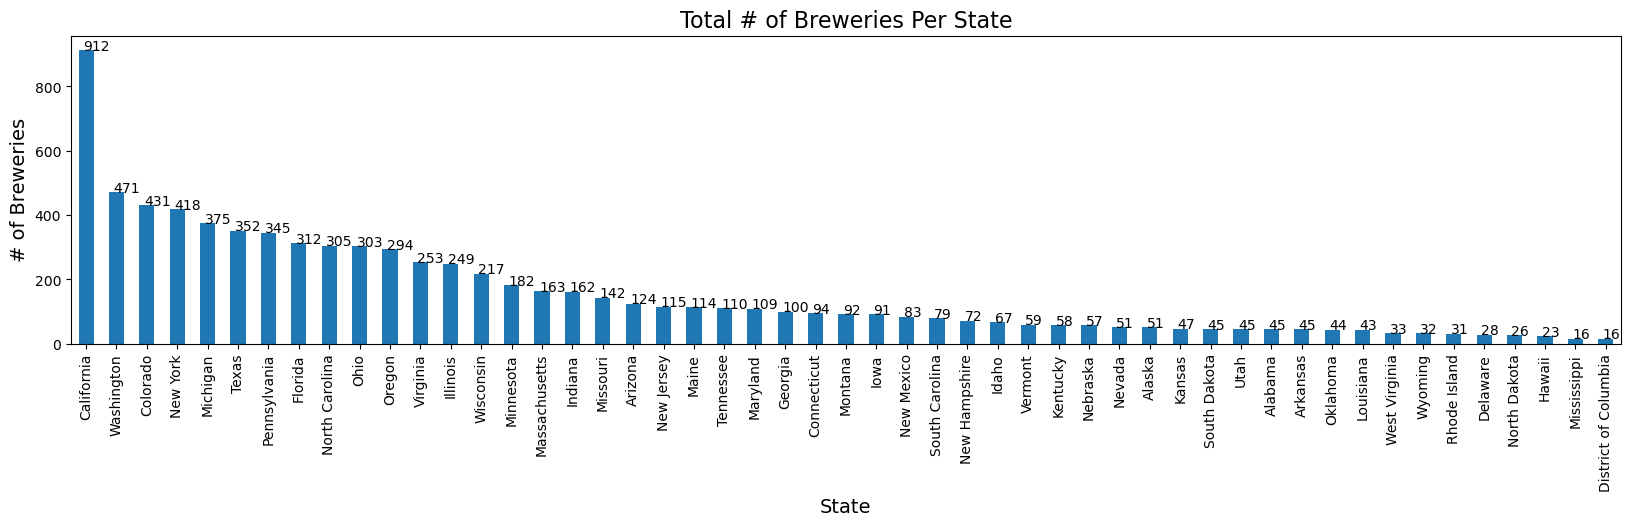

In [32]:
# Generate a bar plot showing total number of breweries by state 
brew_by_state = breweries_complete.groupby(["state"])["brewery_type"].count()
brew_by_state = brew_by_state.sort_values(ascending=False)
brew_by_state_df = pd.DataFrame(brew_by_state)

# Display bar plot
brew_chart = brew_by_state_df.plot(kind="bar", figsize=(20,4), legend=False)

# add value counts above each bar
for i in range(len(brew_by_state_df)):
    plt.text(x=i-0.1 , y=brew_by_state_df.iloc[i,0]+0.5, s=brew_by_state_df.iloc[i,0], size=10)

# label x and y, apply formatting 
brew_chart.set_title("Total # of Breweries Per State", fontsize=16)
brew_chart.set_xlabel("State", fontsize=14)
brew_chart.set_ylabel("# of Breweries", fontsize=14)

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig1_breweries_per_state.png", bbox_inches="tight")
plt.show()

#### Fig1a: Stacked bar plot of brewery-types (no closed) per state

In [33]:
# Identify number of closed breweries in comparison to other types 
breweries_complete["brewery_type"].value_counts()

micro         4114
brewpub       2395
planning       701
regional       213
contract       196
closed         162
large           74
proprietor      69
nano             5
bar              2
Name: brewery_type, dtype: int64

In [53]:
# Drop closed breweries from dataset 
open_planned_breweries = breweries_complete[breweries_complete.brewery_type != "closed"]

# Output csv of only open or planned breweries  
open_planned_breweries.to_csv("csv_building_blocks/breweries_open_planned.csv", index=False)
open_planned_breweries

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6
...,...,...,...,...,...,...,...,...,...,...,...
7927,Zebulon Artisan Ales,micro,8 Merchents Alley,Weaverville,North Carolina,28787-8860,-82.554475,35.715670,North Carolina,28787,7914
7928,Zephyr Brewing Co,micro,1609 E 58th Ave Ste G,Denver,Colorado,80216-1528,-104.981909,39.779835,Colorado,80216,7916
7929,Zero Gravity Craft Brewery,micro,716 Pinte Street,Burlington,Vermont,05401,-73.211024,44.474836,Vermont,05401,7918
7930,Zum Bier,micro,3232 E Monroe St,Waukegan,Illinois,60085,-87.861975,42.358933,Illinois,60085,7930


In [35]:
# Using example from team member Natalia Lopez, count brewery type per state 
open_planned_by_state = open_planned_breweries.groupby(["state", "brewery_type"])["brewery_type"].count()
open_planned_by_state

state    brewery_type
Alabama  brewpub          4
         contract         1
         micro           32
         planning         8
Alaska   brewpub         14
                         ..
Wyoming  brewpub         12
         contract         1
         micro           14
         planning         4
         regional         1
Name: brewery_type, Length: 281, dtype: int64

In [36]:
# Index brewery type per state 
open_planned_by_state_index = open_planned_by_state.index
open_planned_by_state_index

MultiIndex([(  'Alabama',    'brewpub'),
            (  'Alabama',   'contract'),
            (  'Alabama',      'micro'),
            (  'Alabama',   'planning'),
            (   'Alaska',    'brewpub'),
            (   'Alaska',   'contract'),
            (   'Alaska',      'micro'),
            (   'Alaska',   'planning'),
            (   'Alaska',   'regional'),
            (  'Arizona',    'brewpub'),
            ...
            ('Wisconsin',      'micro'),
            ('Wisconsin',       'nano'),
            ('Wisconsin',   'planning'),
            ('Wisconsin', 'proprietor'),
            ('Wisconsin',   'regional'),
            (  'Wyoming',    'brewpub'),
            (  'Wyoming',   'contract'),
            (  'Wyoming',      'micro'),
            (  'Wyoming',   'planning'),
            (  'Wyoming',   'regional')],
           names=['state', 'brewery_type'], length=281)

In [37]:
# Convert index of brewery type per state and replace nan with 0 
open_planned_by_state_index2 = open_planned_by_state.unstack()
open_planned_by_state_index3 = open_planned_by_state_index2.fillna(0)
open_planned_by_state_index3

brewery_type,bar,brewpub,contract,large,micro,nano,planning,proprietor,regional
state,,,,,,,,,
Alabama,0.0,4.0,1.0,0.0,32.0,0.0,8.0,0.0,0.0
Alaska,0.0,14.0,1.0,0.0,29.0,0.0,2.0,0.0,1.0
Arizona,0.0,46.0,4.0,2.0,58.0,0.0,13.0,0.0,1.0
Arkansas,0.0,18.0,1.0,0.0,22.0,0.0,4.0,0.0,0.0
California,0.0,249.0,27.0,15.0,461.0,0.0,67.0,13.0,29.0
Colorado,0.0,138.0,9.0,7.0,222.0,0.0,40.0,4.0,11.0
Connecticut,0.0,11.0,5.0,0.0,49.0,0.0,21.0,0.0,2.0
Delaware,0.0,14.0,0.0,1.0,10.0,0.0,2.0,0.0,1.0
District of Columbia,0.0,6.0,2.0,0.0,5.0,0.0,2.0,0.0,1.0


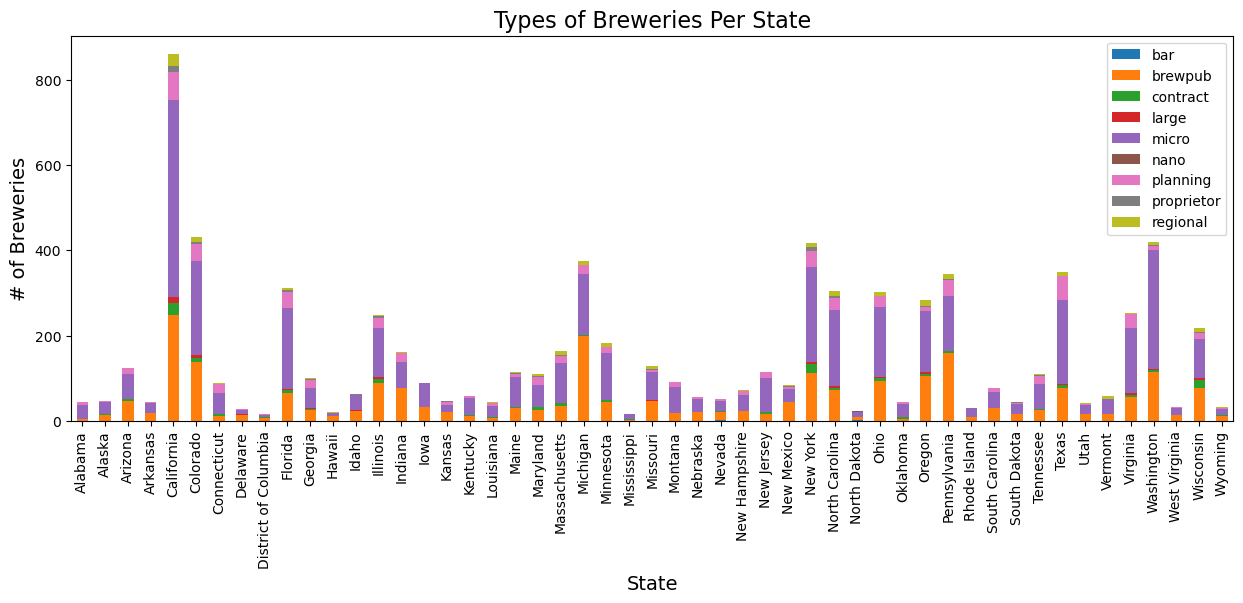

In [38]:
# Display bar plot, label x and y, apply formatting 
stacked_chart = open_planned_by_state_index3.plot(kind="bar", stacked=True, figsize=(15,5))
stacked_chart.set_title("Types of Breweries Per State", fontsize=16)
stacked_chart.set_xlabel("State", fontsize=14)
stacked_chart.set_ylabel("# of Breweries", fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig1a_breweries_types_per_state.png", bbox_inches="tight")
plt.show()

#### Fig2: Total # of micro/brewpubs per state 

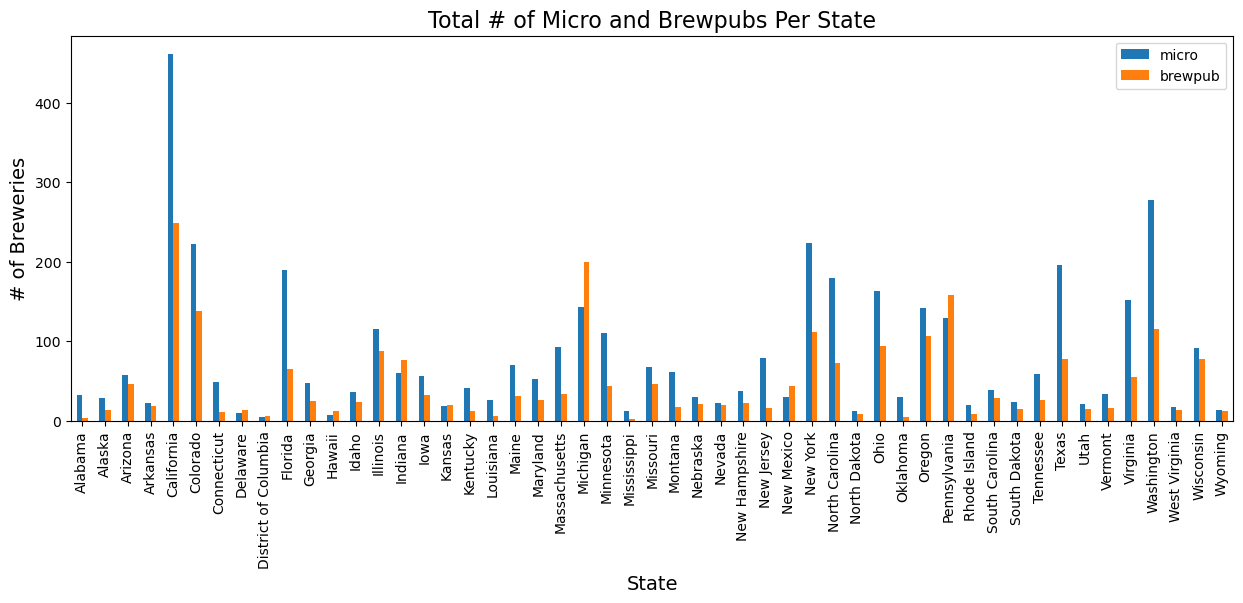

In [42]:
# new DataFrame with only micro and brewpub columns 
micro_brewpub = open_planned_by_state_index3[["micro", "brewpub"]]

# Display bar plot, label x and y, apply formatting 
micro_brewpub_chart = micro_brewpub.plot(kind="bar", figsize=(15,5))

# add value counts above each bar
#for i in range(len(open_planned_by_state_index3)):
    #plt.text(x=i-0.1 , y=open_planned_by_state_index3.iloc[i,0]+0.5, s=open_planned_by_state_index3.iloc[i,0], size=10)

micro_brewpub_chart.set_title("Total # of Micro and Brewpubs Per State", fontsize=16)
micro_brewpub_chart.set_xlabel("State", fontsize=14)
micro_brewpub_chart.set_ylabel("# of Breweries", fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig2_micro_brewpubs_per_state.png", bbox_inches="tight")
plt.show()

#### Fig3: Heat map of micro/brewpubs across the US 

In [77]:
# Filter data to micro and brewpubs 
micro_pub_breweries = breweries_complete.loc[(breweries_complete["brewery_type"] == "pub") + (breweries_complete["brewery_type"] == "micro")]

# Map the micro and brewpubs by latitude and longitude 
map_plot = micro_pub_breweries.hvplot.points(
    "longitude",
    "latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600, 
    title = "Micro & Pub Brewery Locations in the Continental US - Density Map"    
)
map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]

#### Fig4: Total # of closed breweries per state 

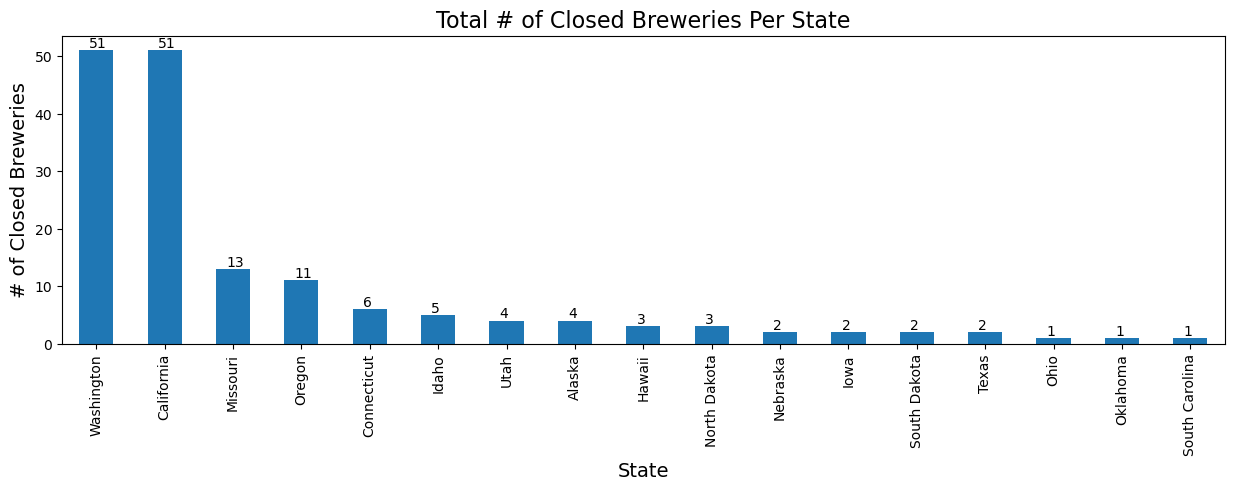

In [44]:
# Pull data for closed breweries 
closed_breweries = breweries_complete.loc[breweries_complete["brewery_type"] == "closed"]

# Generate a bar plot showing total number of closed breweries by state 
closed_brew_by_state = closed_breweries.groupby(["state"])["brewery_type"].count()
closed_brew_by_state = closed_brew_by_state.sort_values(ascending=False)
closed_breweries_df = pd.DataFrame(closed_brew_by_state)

# Display bar plot
closed_brew_chart = closed_breweries_df.plot(kind="bar", figsize=(15,4), legend=False)

# add value counts above each bar
for i in range(len(closed_breweries_df)):
    plt.text(x=i-0.1 , y=closed_breweries_df.iloc[i,0]+0.5, s=closed_breweries_df.iloc[i,0], size=10)

# label x and y, apply formatting 
closed_brew_chart.set_title("Total # of Closed Breweries Per State", fontsize=16)
closed_brew_chart.set_xlabel("State", fontsize=14)
closed_brew_chart.set_ylabel("# of Closed Breweries", fontsize=14)

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig4_closed_breweries_per_state.png", bbox_inches="tight")
plt.show()

#### Fig5: Total # of planned breweries per state 

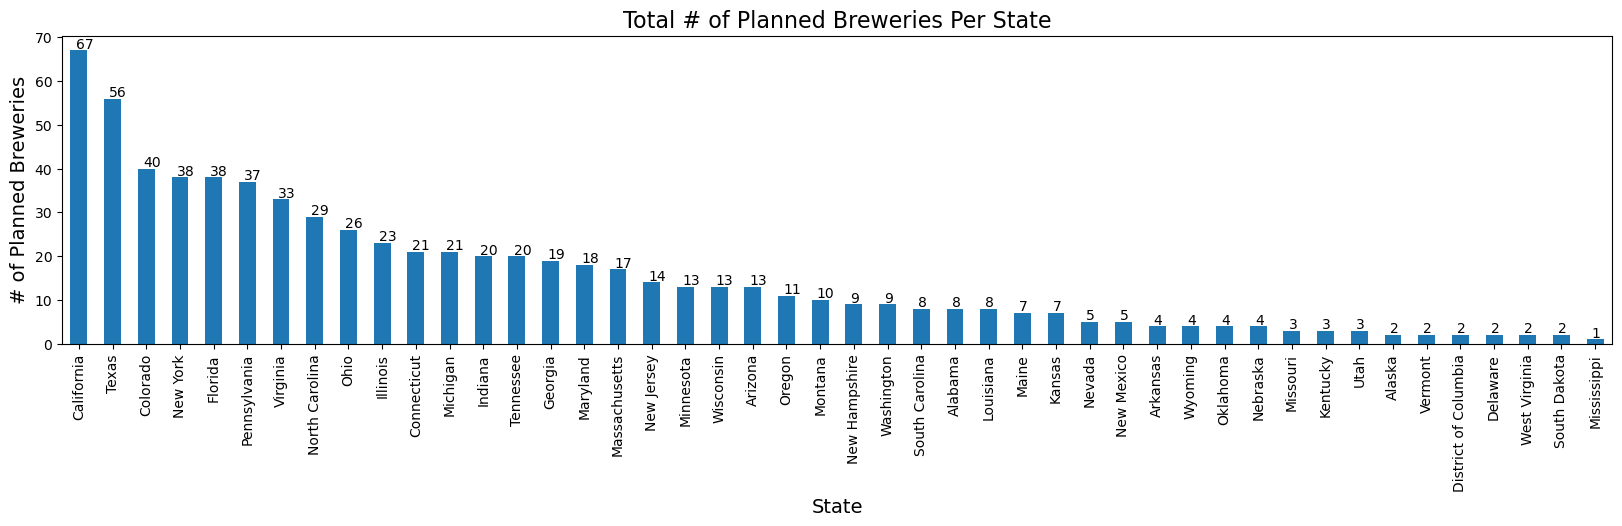

In [45]:
# Pull data for planned breweries
planned_breweries = breweries_complete.loc[breweries_complete["brewery_type"] == "planning"]

# Generate a bar plot showing total number of closed breweries by state 
planned_brew_by_state = planned_breweries.groupby(["state"])["brewery_type"].count()
planned_brew_by_state = planned_brew_by_state.sort_values(ascending=False)
planned_breweries_df = pd.DataFrame(planned_brew_by_state)

# Display bar plot, label x and y, apply formatting 
planned_brew_chart = planned_breweries_df.plot(kind="bar", figsize=(20,4), legend=False)

# add value counts above each bar
for i in range(len(planned_breweries_df)):
    plt.text(x=i-0.1 , y=planned_breweries_df.iloc[i,0]+0.5, s=planned_breweries_df.iloc[i,0], size=10)

planned_brew_chart.set_title("Total # of Planned Breweries Per State", fontsize=16)
planned_brew_chart.set_xlabel("State", fontsize=14)
planned_brew_chart.set_ylabel("# of Planned Breweries", fontsize=14)

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig5_planned_breweries_per_state.png", bbox_inches="tight")
plt.show()

#### Fig6: Top 5 states for micro/brewpub concentration 

In [46]:
# Filter columns to only show micro and brewpub 
micro_brewpub = open_planned_by_state_index3[["micro", "brewpub"]]
micro_brewpub

brewery_type,micro,brewpub
state,,
Alabama,32.0,4.0
Alaska,29.0,14.0
Arizona,58.0,46.0
Arkansas,22.0,18.0
California,461.0,249.0
Colorado,222.0,138.0
Connecticut,49.0,11.0
Delaware,10.0,14.0
District of Columbia,5.0,6.0


In [47]:
# create new DataFrame with only micro and brewpub columns and reset index to get state into separate column 
micro_brewpub = open_planned_by_state_index3[["micro", "brewpub"]]
micro_brewpub_df = pd.DataFrame(micro_brewpub)
micro_brewpub_reset = micro_brewpub_df.reset_index()
micro_brewpub_reset

brewery_type,state,micro,brewpub
0,Alabama,32.0,4.0
1,Alaska,29.0,14.0
2,Arizona,58.0,46.0
3,Arkansas,22.0,18.0
4,California,461.0,249.0
5,Colorado,222.0,138.0
6,Connecticut,49.0,11.0
7,Delaware,10.0,14.0
8,District of Columbia,5.0,6.0
9,Florida,190.0,65.0


In [48]:
# Add total number of micro and brewpubs to each state row and display data in descending number of breweries
sum_column = micro_brewpub_reset["micro"] + micro_brewpub_reset["brewpub"]
micro_brewpub_reset["Total"] = sum_column
sorted_count = micro_brewpub_reset.sort_values(by=["Total"], ascending=False)
sorted_count

brewery_type,state,micro,brewpub,Total
4,California,461.0,249.0,710.0
47,Washington,278.0,115.0,393.0
5,Colorado,222.0,138.0,360.0
22,Michigan,143.0,199.0,342.0
32,New York,224.0,111.0,335.0
38,Pennsylvania,129.0,158.0,287.0
43,Texas,196.0,77.0,273.0
35,Ohio,163.0,94.0,257.0
9,Florida,190.0,65.0,255.0
33,North Carolina,179.0,72.0,251.0


In [49]:
# Filter data to only show for 5 states with most micro + brewpubs 
top_states = open_planned_by_state_index3.loc[["California", "Washington", "Colorado", "Michigan", "New York"]]
top_states

brewery_type,bar,brewpub,contract,large,micro,nano,planning,proprietor,regional
state,,,,,,,,,
California,0.0,249.0,27.0,15.0,461.0,0.0,67.0,13.0,29.0
Washington,0.0,115.0,4.0,3.0,278.0,2.0,9.0,2.0,7.0
Colorado,0.0,138.0,9.0,7.0,222.0,0.0,40.0,4.0,11.0
Michigan,0.0,199.0,3.0,0.0,143.0,0.0,21.0,0.0,9.0
New York,0.0,111.0,22.0,4.0,224.0,0.0,38.0,10.0,9.0


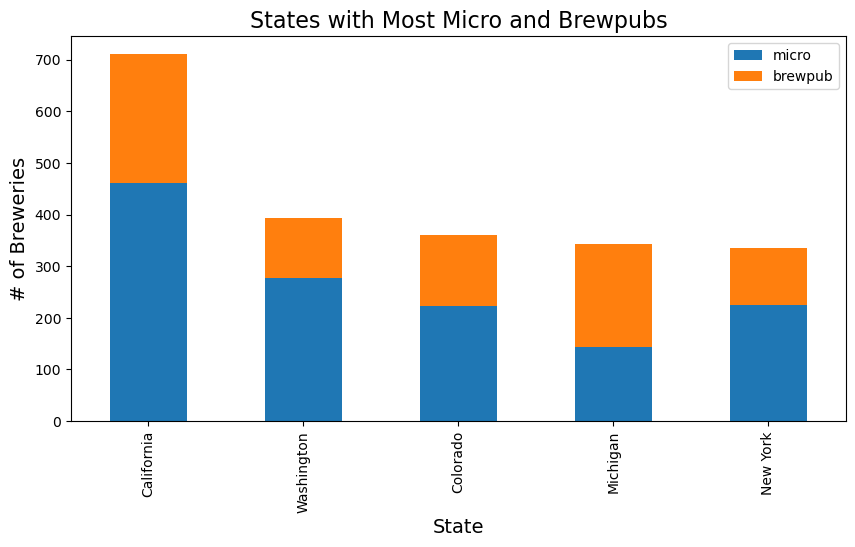

In [50]:
# Display bar plot, label x and y, apply formatting 
y = []
top_states_chart = top_states.plot(kind="bar", y=["micro", "brewpub"], stacked=True, figsize=(10,5))
top_states_chart.set_title("States with Most Micro and Brewpubs", fontsize=16)
top_states_chart.set_xlabel("State", fontsize=14)
top_states_chart.set_ylabel("# of Breweries", fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig6_top_states_micro_brewpubs.png", bbox_inches="tight")
plt.show()

#### Fig7: Tail 5 states for micro/brewpub concentration 

Note - Excluded DC as it technically is not a state 

In [51]:
# Filter data to only show for 5 states with least micro + brewpubs 
bottom_states = open_planned_by_state_index3.loc[["Wyoming", "Delaware", "North Dakota", "Hawaii", "Mississippi"]]
bottom_states

brewery_type,bar,brewpub,contract,large,micro,nano,planning,proprietor,regional
state,,,,,,,,,
Wyoming,0.0,12.0,1.0,0.0,14.0,0.0,4.0,0.0,1.0
Delaware,0.0,14.0,0.0,1.0,10.0,0.0,2.0,0.0,1.0
North Dakota,1.0,8.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0
Hawaii,0.0,12.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0
Mississippi,0.0,2.0,1.0,0.0,12.0,0.0,1.0,0.0,0.0


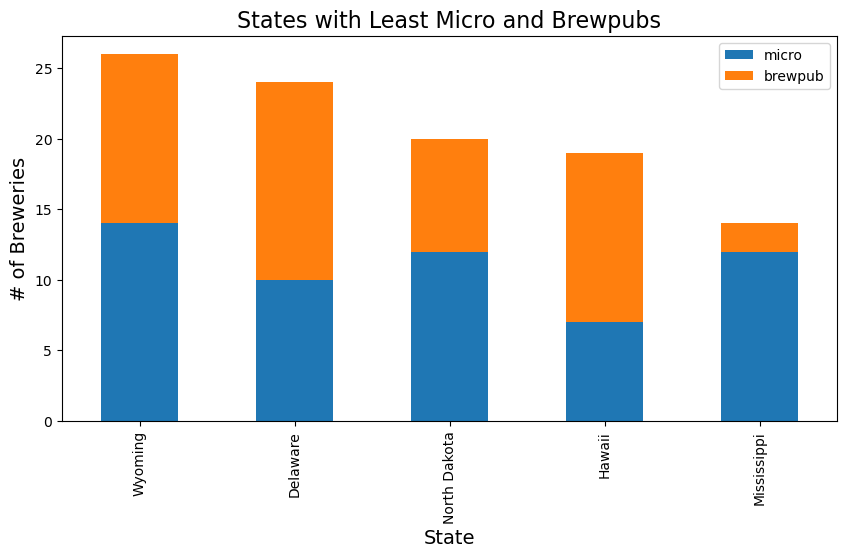

In [52]:
# Display bar plot, label x and y, apply formatting 
y = []
bottom_states_chart = bottom_states.plot(kind="bar", y=["micro", "brewpub"], stacked=True, figsize=(10,5))
bottom_states_chart.set_title("States with Least Micro and Brewpubs", fontsize=16)
bottom_states_chart.set_xlabel("State", fontsize=14)
bottom_states_chart.set_ylabel("# of Breweries", fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig7_tail_states_micro_brewpubs.png", bbox_inches="tight")
plt.show()

### Analysis - Part 2: What cities in the US have the most micro and brewpubs (and which have the least?)

#### Fig8: Top 3 cities from top state for micro/brewpub concentration 

In [54]:
# Filter complete data by California (top) and Mississippi (tail)
top_tail_states = breweries_complete.loc[(breweries_complete["state"] == "California") | (breweries_complete["state"] == "Mississippi")]
top_tail_states2 = top_tail_states[["brewery_type", "city", "state"]]
top_tail_states2_df = pd.DataFrame(top_tail_states2)
top_tail_states2_df

,brewery_type,city,state
1,large,San Diego,California
11,closed,Petaluma,California
23,micro,Westlake Village,California
31,micro,okolona,Mississippi
33,micro,Mariposa,California
...,...,...,...
6857,micro,Starkville,Mississippi
6888,micro,Greenville,Mississippi
7336,brewpub,San Diego,California
7428,contract,Los Angeles,California


In [56]:
# Narrow filtered data for CA and MS down to only those that have micro/brewpubs 
micro_brewpub_city = top_tail_states2_df.loc[(top_tail_states2_df["brewery_type"] == "micro") | (top_tail_states2_df["brewery_type"] == "brewpub")]
micro_brewpub_city_df = pd.DataFrame(micro_brewpub_city)
micro_brewpub_city_df

,brewery_type,city,state
23,micro,Westlake Village,California
31,micro,okolona,Mississippi
33,micro,Mariposa,California
44,brewpub,Santa Rosa,California
51,brewpub,San Francisco,California
...,...,...,...
6117,brewpub,Ocean Springs,Mississippi
6162,brewpub,Hesperia,California
6857,micro,Starkville,Mississippi
6888,micro,Greenville,Mississippi


In [57]:
# Count brewery type per city 
city_concentration = micro_brewpub_city_df.groupby(["state", "city", "brewery_type"])["brewery_type"].count()
city_concentration

state        city             brewery_type
California   Agoura Hills     brewpub         2
             Alameda          micro           3
             Alamo            micro           1
             Aliso Viejo      brewpub         1
             American Canyon  brewpub         1
                                             ..
Mississippi  Ocean Springs    micro           1
             Starkville       micro           1
             Vicksburg        brewpub         1
             Water Valley     micro           1
             okolona          micro           1
Name: brewery_type, Length: 359, dtype: int64

In [58]:
# Index brewery type per city 
city_concentration_index = city_concentration.index
city_concentration_index

MultiIndex([( 'California',    'Agoura Hills', 'brewpub'),
            ( 'California',         'Alameda',   'micro'),
            ( 'California',           'Alamo',   'micro'),
            ( 'California',     'Aliso Viejo', 'brewpub'),
            ( 'California', 'American Canyon', 'brewpub'),
            ( 'California',         'Anaheim', 'brewpub'),
            ( 'California',         'Anaheim',   'micro'),
            ( 'California',    'Apple Valley', 'brewpub'),
            ( 'California',    'Apple Valley',   'micro'),
            ( 'California',         'Arcadia',   'micro'),
            ...
            ('Mississippi',         'Jackson',   'micro'),
            ('Mississippi',            'Kiln',   'micro'),
            ('Mississippi',          'Laurel',   'micro'),
            ('Mississippi',         'Natchez',   'micro'),
            ('Mississippi',   'Ocean Springs', 'brewpub'),
            ('Mississippi',   'Ocean Springs',   'micro'),
            ('Mississippi',      'Starkv

In [59]:
# Convert index of brewery type per city and replace nan with 0 
city_concentration_index2 = city_concentration.unstack()
city_concentration_index3 = city_concentration_index2.fillna(0)
city_concentration_index3

brewery_type                 brewpub  micro
state       city                           
California  Agoura Hills         2.0    0.0
            Alameda              0.0    3.0
            Alamo                0.0    1.0
            Aliso Viejo          1.0    0.0
            American Canyon      1.0    0.0
...                              ...    ...
Mississippi Ocean Springs        1.0    1.0
            Starkville           0.0    1.0
            Vicksburg            1.0    0.0
            Water Valley         0.0    1.0
            okolona              0.0    1.0

[282 rows x 2 columns]

In [60]:
# Add total number of micro and brewpubs to each city row and display data in descending number of breweries
sum_column2 = city_concentration_index3["micro"] + city_concentration_index3["brewpub"]
city_concentration_index3["Total"] = sum_column2
sorted_count2 = city_concentration_index3.sort_values(by=["Total"], ascending=False)
sorted_count2_df = pd.DataFrame(sorted_count2)
city_concentration_reset = sorted_count2_df.reset_index()
city_concentration_reset

brewery_type,state,city,brewpub,micro,Total
0,California,San Diego,22.0,45.0,67.0
1,California,San Francisco,17.0,15.0,32.0
2,California,Sacramento,5.0,13.0,18.0
3,California,Los Angeles,6.0,12.0,18.0
4,California,Vista,3.0,11.0,14.0
...,...,...,...,...,...
277,California,Marina,0.0,1.0,1.0
278,California,Marina del Rey,1.0,0.0,1.0
279,California,Mariposa,0.0,1.0,1.0
280,California,McCloud,1.0,0.0,1.0


In [61]:
# Remove state column 
top_cities = city_concentration_reset[["city", "micro", "brewpub", "Total"]]
top_cities

brewery_type,city,micro,brewpub,Total
0,San Diego,45.0,22.0,67.0
1,San Francisco,15.0,17.0,32.0
2,Sacramento,13.0,5.0,18.0
3,Los Angeles,12.0,6.0,18.0
4,Vista,11.0,3.0,14.0
...,...,...,...,...
277,Marina,1.0,0.0,1.0
278,Marina del Rey,0.0,1.0,1.0
279,Mariposa,1.0,0.0,1.0
280,McCloud,0.0,1.0,1.0


In [62]:
# Set city column as index 
top_cities_reset = top_cities.set_index("city")
top_cities_reset

brewery_type,micro,brewpub,Total
city,,,
San Diego,45.0,22.0,67.0
San Francisco,15.0,17.0,32.0
Sacramento,13.0,5.0,18.0
Los Angeles,12.0,6.0,18.0
Vista,11.0,3.0,14.0
...,...,...,...
Marina,1.0,0.0,1.0
Marina del Rey,0.0,1.0,1.0
Mariposa,1.0,0.0,1.0


In [63]:
# Filter data to only show three cities in CA with most micro + brewpubs 
top_cities2 = top_cities_reset.loc[["San Diego","San Francisco", "Los Angeles"]]
top_cities2

brewery_type,micro,brewpub,Total
city,,,
San Diego,45.0,22.0,67.0
San Francisco,15.0,17.0,32.0
Los Angeles,12.0,6.0,18.0


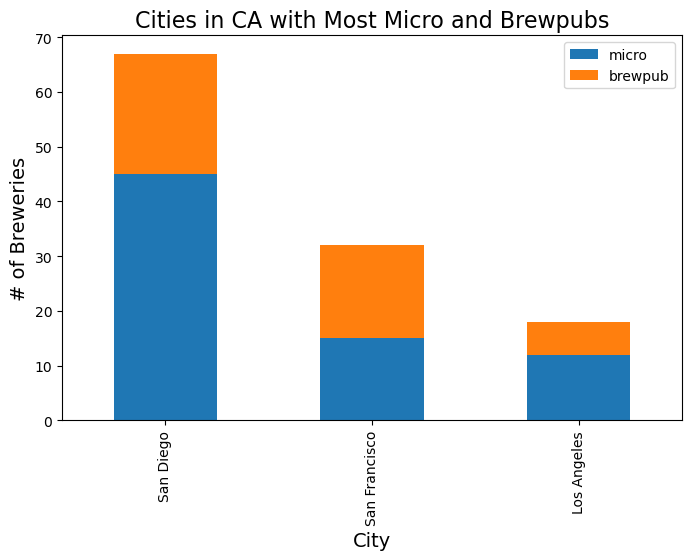

In [64]:
# Display bar plot, label x and y, apply formatting 
y = []
top_cities_chart = top_cities2.plot(kind="bar", y=["micro", "brewpub"], stacked=True, figsize=(8,5))
top_cities_chart.set_title("Cities in CA with Most Micro and Brewpubs", fontsize=16)
top_cities_chart.set_xlabel("City", fontsize=14)
top_cities_chart.set_ylabel("# of Breweries", fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig8_top_CA_cities_micro_brewpubs.png", bbox_inches="tight")
plt.show()

#### Figure8a: Top state (CA) density close up 

In [78]:
# Filter data to California 
california_breweries = breweries_complete.loc[breweries_complete["state"] == "California"]

# Map the micro and brewpubs by latitude and longitude 
map_plot1 = california_breweries.hvplot.points(
    "longitude",
    "latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600, 
    hover_cols = ["name", "brewery_type", "city"],
    title = "Micro & Pub Brewery Locations in California - Density Map"    
)
map_plot1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (name,brewery_type,city)

#### Fig9: Top 3 cities from tail state for micro/brewpub concentration 

Did not use Ocean Springs as it does not appear in the merged_df_cleaned data 

In [69]:
# Pull only Mississippi data rows to find top three cities for micro/brewpubs 
city_concentration_reset2 = city_concentration_reset.loc[city_concentration_reset["state"] == "Mississippi"]
city_concentration_reset2

brewery_type,state,city,brewpub,micro,Total
109,Mississippi,Ocean Springs,1.0,1.0,2.0
120,Mississippi,Starkville,0.0,1.0,1.0
121,Mississippi,Vicksburg,1.0,0.0,1.0
130,Mississippi,Water Valley,0.0,1.0,1.0
132,Mississippi,Biloxi,0.0,1.0,1.0
134,Mississippi,Greenville,0.0,1.0,1.0
136,Mississippi,Gulfport,0.0,1.0,1.0
139,Mississippi,Hattiesburg,0.0,1.0,1.0
141,Mississippi,Jackson,0.0,1.0,1.0
142,Mississippi,Kiln,0.0,1.0,1.0


In [70]:
# Drop state coulmn and set city column as index 
tail_cities = city_concentration_reset2.drop(["state"], axis=1)
tail_cities_reset = tail_cities.set_index("city")
tail_cities_reset

brewery_type,brewpub,micro,Total
city,,,
Ocean Springs,1.0,1.0,2.0
Starkville,0.0,1.0,1.0
Vicksburg,1.0,0.0,1.0
Water Valley,0.0,1.0,1.0
Biloxi,0.0,1.0,1.0
Greenville,0.0,1.0,1.0
Gulfport,0.0,1.0,1.0
Hattiesburg,0.0,1.0,1.0
Jackson,0.0,1.0,1.0


In [71]:
# Filter data to only show three cities in MS with most micro + brewpubs 
tail_cities_reset2 = tail_cities_reset.loc[["Jackson", "Hattiesburg", "Gulfport"]]
tail_cities_reset2

brewery_type,brewpub,micro,Total
city,,,
Jackson,0.0,1.0,1.0
Hattiesburg,0.0,1.0,1.0
Gulfport,0.0,1.0,1.0


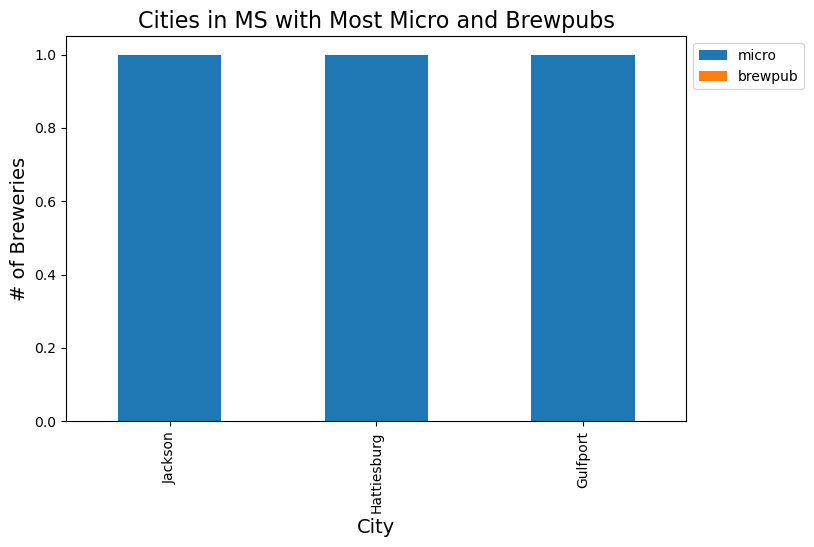

In [81]:
# Display bar plot, label x and y, apply formatting 
y = []
tail_cities_chart = tail_cities_reset2.plot(kind="bar", y=["micro", "brewpub"], stacked=True, figsize=(8,5))
tail_cities_chart.set_title("Cities in MS with Most Micro and Brewpubs", fontsize=16)
tail_cities_chart.set_xlabel("City", fontsize=14)
tail_cities_chart.set_ylabel("# of Breweries", fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Save an image of the chart and print it to the screen
plt.savefig("final_figures/fig9_top_MS_cities_micro_brewpubs.png", bbox_inches="tight")
plt.show()

#### Figure9a: Tail state (MS) density close up 

In [79]:
# Filter data to Mississippi
mississippi_breweries = breweries_complete.loc[breweries_complete["state"] == "Mississippi"]

# Map the micro and brewpubs by latitude and longitude 
map_plot3 = mississippi_breweries.hvplot.points(
    "longitude",
    "latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600, 
    hover_cols = ["name", "brewery_type", "city"],
    title = "Micro & Pub Brewery Locations in Mississippi - Density Map"    
)
map_plot3

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (name,brewery_type,city)

### Analysis - Part 3: What are the demographic characteristics of the city(s) with the most micro and/or brewpubs and how do they compare the demographics of the city(s) with the least micro/and or brewpubs? 

### Figures 10-16 - using merged_df_cleaned data (Natalia)

Preparing the dataset for plots

In [3]:
# Study data files
last_path = "./csv_building_blocks/merged_df_cleaned.csv"

# Read the brewery data and the study results
last_df = pd.read_csv(last_path, index_col="City")

# Display dataframe
last_df.head()

,name,brewery_type,address_1,State,postal_code,longitude,latitude,state_x,zip_code,brewery_id,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
City,,,,,,,,,,,,,,,,,,,,,
Norman,(405) Brewing Co,micro,1716 Topeka St,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069.0,1,...,71963.0,59063.0,28261.0,31076.0,18444.0,44975.0,46495.0,57307.0,53446.0,3861.0
San Diego,10 Barrel Brewing Co,large,1501 E St,California,92101-6618,-117.129593,32.714813,California,92101.0,3,...,93042.0,107093.0,74377.0,48579.0,1150367.0,502249.0,457320.0,555456.0,521000.0,34456.0
Bend,10 Barrel Brewing Co,large,62970 18th St,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701.0,4,...,55398.0,86510.0,37802.0,49717.0,32362.0,32384.0,30907.0,47882.0,44620.0,3262.0
Bend,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703.0,5,...,55398.0,86510.0,37802.0,49717.0,32362.0,32384.0,30907.0,47882.0,44620.0,3262.0
Portland,10 Barrel Brewing Co,large,1411 NW Flanders St,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209.0,6,...,36125.0,79590.0,40542.0,46590.0,50737.0,229443.0,227784.0,303483.0,286734.0,16749.0


In [4]:
# Show column names
last_df.columns

Index(['name', 'brewery_type', 'address_1', 'State', 'postal_code',
       'longitude', 'latitude', 'state_x', 'zip_code', 'brewery_id', 'NAME',
       'state_y', 'place', 'population_total', 'population_male',
       'population_female', 'population_median_age',
       'population_median_age_male', 'population_median_age_female',
       'population_total_2', 'population_18_to_24', 'population_25_to_34',
       'population_35_to_44', 'population_45_to_54', 'population_55_to_64',
       'income_household', 'income_household_median', 'income_family_median',
       'income_nonfamily_median', 'earnings_median', 'employment_total',
       'employment_male', 'employment_female', 'occupancy_status_total',
       'occupancy_status_occupied', 'occupancy_status_vacant'],
      dtype='object')

In [5]:
# Plot Demographics per state and city (MultiIndex)
SummaryCities_df = last_df.groupby(['State', 'City'])[['population_total','population_male',  'population_female', 'population_median_age',
       'population_median_age_male', 'population_median_age_female', 'population_total_2','population_18_to_24','population_25_to_34','population_35_to_44','population_45_to_54','population_55_to_64','income_household', 'income_household_median','income_family_median','income_nonfamily_median','earnings_median','employment_total','employment_male' , 'employment_female','occupancy_status_total', 'occupancy_status_occupied', 'occupancy_status_vacant']].mean()
SummaryCities_df

population_total  population_male  population_female   
State   City                                                                 
Alabama Alabaster              33670.0          16058.0            17612.0  \
        Anniston               21545.0           9639.0            11906.0   
        Birmingham            196410.0          94696.0           101714.0   
        Decatur                57754.0          28253.0            29501.0   
        Dothan                 71283.0          33706.0            37577.0   
...                                ...              ...                ...   
Wyoming Cheyenne               65048.0          31310.0            33738.0   
        Gillette               33061.0          17614.0            15447.0   
        Laramie                28531.0          14477.0            14054.0   
        Rock Springs           20787.0          10991.0             9796.0   
        Sheridan               20724.0           9987.0            10737.0   

                      population_median_age  population_median_age_male   
State   City                                                              
Alabama Alabaster                      42.0                        42.4  \
        Anniston                       42.4                        41.8   
        Birmingham                     37.2                        32.9   
        Decatur                        42.1                        42.1   
        Dothan                         40.5                        38.9   
...                                     ...                         ...   
Wyoming Cheyenne                       39.3                        39.7   
        Gillette                       36.0                        36.2   
        Laramie                        28.3                        29.3   
        Rock Springs                   37.4                        37.3   
        Sheridan                       38.6                        39.8   

                      population_median_age_female  population_total_2   
State   City                                                             
Alabama Alabaster                             40.7             33670.0  \
        Anniston                              43.1             21545.0   
        Birmingham                            40.1            196410.0   
        Decatur                               42.1             57754.0   
        Dothan                                42.2             71283.0   
...                                            ...                 ...   
Wyoming Cheyenne                              38.4             33061.0   
        Gillette                              35.3             28531.0   
        Laramie                               27.0             20787.0   
        Rock Springs                          37.6             20724.0   
        Sheridan                              38.3             41914.0   

                      population_18_to_24  population_25_to_34   
State   City                                                     
Alabama Alabaster                  2231.0               3222.0  \
        Anniston                   2375.0               2276.0   
        Birmingham                23198.0              31770.0   
        Decatur                    4089.0               7244.0   
        Dothan                     5751.0               8946.0   
...                                   ...                  ...   
Wyoming Cheyenne                   1110.0               4962.0   
        Gillette                   9740.0               4821.0   
        Laramie                    2045.0               2970.0   
        Rock Springs               2097.0               2177.0   
        Sheridan                   4840.0               3435.0   

                      population_35_to_44  ...  income_household_median   
State   City                               ...                            
Alabama Alabaster                  5060.0  ...             

In [6]:
# Plot Summary per state
Summary_df = last_df.groupby('State')[['population_total','population_male',  'population_female', 'population_median_age',
       'population_median_age_male', 'population_median_age_female', 'population_total_2','population_18_to_24','population_25_to_34','population_35_to_44','population_45_to_54','population_55_to_64','income_household', 'income_household_median','income_family_median','income_nonfamily_median','earnings_median','employment_total','employment_male' , 'employment_female','occupancy_status_total', 'occupancy_status_occupied', 'occupancy_status_vacant']].mean()
Summary_df

,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,population_total_2,population_18_to_24,population_25_to_34,population_35_to_44,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
State,,,,,,,,,,,,,,,,,,,,,
Alabama,1.354198e+05,6.566439e+04,6.975539e+04,37.355263,35.334211,39.007895,135419.789474,15561.631579,20733.763158,17560.210526,...,56452.236842,72843.184211,3.918626e+04,37058.578947,110321.342105,4.302618e+04,4.504195e+04,6.738192e+04,5.840645e+04,8975.473684
Alaska,2.113497e+05,1.081875e+05,1.031622e+05,35.580000,34.510000,36.120000,211349.700000,20294.900000,34768.000000,31230.300000,...,82591.500000,103638.500000,4.803240e+04,41853.800000,165856.200000,7.170450e+04,6.715160e+04,8.815370e+04,8.055660e+04,7597.100000
Arizona,4.956868e+05,2.485697e+05,2.471171e+05,37.696262,37.060748,38.342991,446381.672897,45879.093458,70466.794393,59939.579439,...,71187.943925,87112.766355,4.713595e+04,40389.383178,396322.878505,1.666152e+05,1.618841e+05,2.079479e+05,1.922823e+05,15665.570093
Arkansas,1.114171e+05,5.315462e+04,5.826244e+04,34.664706,33.982353,35.017647,41567.705882,5237.205882,5703.352941,5011.911765,...,59020.205882,73462.411765,3.068438e+04,36750.264706,87850.117647,3.510415e+04,3.720391e+04,5.276965e+04,4.713650e+04,5633.147059
California,5.236191e+05,2.638434e+05,2.597757e+05,37.509241,36.566621,38.566345,71981.586207,6548.404138,10584.028966,10010.820690,...,93356.617931,110188.357241,-8.623454e+05,48253.955862,433147.233103,1.838463e+05,1.748875e+05,2.100992e+05,1.940117e+05,16087.492414
Colorado,3.213297e+05,1.615129e+05,1.598168e+05,35.859935,35.297394,36.448534,49637.006515,4968.449511,7434.605863,7221.687296,...,82940.013029,109274.263844,4.750764e+04,44702.188925,266444.592834,1.153266e+05,1.096616e+05,1.511754e+05,1.416334e+05,9541.996743
Connecticut,9.512182e+04,4.648900e+04,4.863282e+04,36.254545,34.786364,37.886364,53694.318182,5838.772727,7669.863636,6765.363636,...,61391.909091,76848.545455,4.872050e+04,36002.863636,77687.045455,3.199077e+04,3.223141e+04,4.183245e+04,3.773627e+04,4096.181818
Delaware,4.713892e+04,2.323592e+04,2.390300e+04,35.183333,32.908333,36.250000,309976.250000,31288.333333,65430.666667,50143.166667,...,57607.750000,97688.916667,5.430917e+04,33580.916667,40072.333333,1.664742e+04,1.554858e+04,2.230117e+04,1.957100e+04,2730.166667
District of Columbia,6.700500e+05,3.190250e+05,3.510250e+05,34.800000,34.700000,35.000000,95779.000000,13294.000000,15015.000000,9033.000000,...,90088.000000,136184.000000,4.628800e+04,72457.000000,553437.000000,2.241980e+05,2.436240e+05,3.574820e+05,3.195650e+05,37917.000000


FILTER TOP STATE AND TOP CITIES

In [7]:
# Filter Cities in top State: CALIFORNIA
topcities = SummaryCities_df.loc[['California'],:]
topcities

population_total  population_male   
State      City                                                 
California Alameda                   76352.0          37267.0  \
           Aliso Viejo               51829.0          25155.0   
           American Canyon           23371.0          11580.0   
           Anaheim                  345935.0         168784.0   
           Apple Valley              76217.0          39795.0   
...                                      ...              ...   
           Windsor                   26040.0          13296.0   
           Woodland                  61391.0          28925.0   
           Yorba Linda               67992.0          32443.0   
           Yuba City                 69544.0          36080.0   
           Yucaipa                   54739.0          24163.0   

                            population_female  population_median_age   
State      City                                                        
California Alameda                    39085.0                   40.6  \
           Aliso Viejo                26674.0                   37.3   
           American Canyon            11791.0                   38.7   
           Anaheim                   177151.0                   37.2   
           Apple Valley               36422.0                   36.8   
...                                       ...                    ...   
           Windsor                    12744.0                   44.1   
           Woodland                   32466.0                   36.6   
           Yorba Linda                35549.0                   45.4   
           Yuba City                  33464.0                   36.5   
           Yucaipa                    30576.0                   34.8   

                            population_median_age_male   
State      City                                          
California Alameda                                39.9  \
           Aliso Viejo                            37.2   
           American Canyon                        35.3   
           Anaheim                                36.6   
           Apple Valley                           36.8   
...                                                ...   
           Windsor                                40.2   
           Woodland                               35.3   
           Yorba Linda                            46.1   
           Yuba City                              34.1   
           Yucaipa                                38.6   

                            population_median_age_female  population_total_2   
State      City                                                                
California Alameda                                  41.5             21056.0  \
           Aliso Viejo                              37.5             46510.0   
           American Canyon                          40.3            345935.0   
           Anaheim                                  37.9             44991.0   
           Apple Valley                             36.8             55335.0   
...                                                  ...                 ...   
           Windsor                                  49.9             61391.0   
           Woodland                                 37.4             67992.0   
           Yorba Linda                              44.6             69544.0   
           Yuba City                                39.8             54739.0   
           Yucaipa                                  33.3             21140.0   

                            population_18_to_24  population_25_to_34   
State      City                                                        
California Alameda                       1045.0               2939.0  \
           Aliso Viejo                   2916.0               3980.0   
           American Canyon              30526.0              54439.0   
           Anaheim                       2674.0               4298.0   
           Apple 

In [8]:
# FIlter top 3 cities in topState: CALIFORNIA
Top3cities = topcities.loc['California', ['San Diego', 'San Francisco', 'Los Angeles'], :]
Top3cities

population_total  population_male   
State      City                                               
California San Diego             1381600.0         707804.0  \
           San Francisco          815201.0         417313.0   
           Los Angeles           3849306.0        1920499.0   

                          population_female  population_median_age   
State      City                                                      
California San Diego               673796.0                   35.9  \
           San Francisco           397888.0                   40.4   
           Los Angeles            1928807.0                   37.0   

                          population_median_age_male   
State      City                                        
California San Diego                            34.9  \
           San Francisco                        40.1   
           Los Angeles                          36.3   

                          population_median_age_female  population_total_2   
State      City                                                              
California San Diego                              37.0             34070.0  \
           San Francisco                          41.0             38670.0   
           Los Angeles                            37.8             46398.0   

                          population_18_to_24  population_25_to_34   
State      City                                                      
California San Diego                   2826.0               3995.0  \
           San Francisco               2465.0               5049.0   
           Los Angeles                 4401.0               8965.0   

                          population_35_to_44  ...  income_household_median   
State      City                                ...                            
California San Diego                   4564.0  ...                  93042.0  \
           San Francisco               6244.0  ...                 121826.0   
           Los Angeles                 4765.0  ...                  70372.0   

                          income_family_median  income_nonfamily_median   
State      City                                                           
California San Diego                  107093.0                  74377.0  \
           San Francisco              150429.0                  66875.0   
           Los Angeles                 82317.0                  41376.0   

                          earnings_median  employment_total  employment_male   
State      City                                                                
California San Diego              48579.0         1150367.0         502249.0  \
           San Francisco          76010.0          713617.0         299502.0   
           Los Angeles            36764.0         3178578.0        1341561.0   

                          employment_female  occupancy_status_total   
State      City                                                       
California San Diego               457320.0                555456.0  \
           San Francisco           271633.0                412269.0   
           Los Angeles            1309942.0               1542391.0   

                          occupancy_status_occupied  occupancy_status_vacant  
State      City                                                               
California San Diego                       521000.0                  34456.0  
           San Francisco                   350796.0                  61473.0  
           Los Angeles                    1410594.0                 131797.0  

[3 rows x 23 columns]

FILTER TAIL STATE AND TAIL CITIES

In [9]:
# Filter Cities in tail State: MISSISSIPPI
tailcities = SummaryCities_df.loc[['Mississippi'],:]
tailcities

population_total  population_male  population_female   
State       City                                                                
Mississippi Biloxi                49253.0          23362.0            25891.0  \
            Greenville            31363.0          15209.0            16154.0   
            Gulfport              72096.0          35421.0            36675.0   
            Hattiesburg           45704.0          21170.0            24534.0   
            Jackson              149813.0          69597.0            80216.0   
            Meridian              34425.0          16929.0            17496.0   
            Starkville            24652.0          11709.0            12943.0   
            Vicksburg             22832.0          11003.0            11829.0   

                         population_median_age  population_median_age_male   
State       City                                                             
Mississippi Biloxi                        38.5                        37.0  \
            Greenville                    37.9                        34.8   
            Gulfport                      36.7                        37.7   
            Hattiesburg                   29.7                        32.1   
            Jackson                       34.0                        32.0   
            Meridian                      41.0                        38.9   
            Starkville                    27.2                        24.3   
            Vicksburg                     36.5                        35.2   

                         population_median_age_female  population_total_2   
State       City                                                            
Mississippi Biloxi                               38.9             25366.0  \
            Greenville                           40.6             72096.0   
            Gulfport                             36.5             45704.0   
            Hattiesburg                          27.5             20436.0   
            Jackson                              37.0             27715.0   
            Meridian                             43.8             40276.0   
            Starkville                           31.4             37671.0   
            Vicksburg                            39.1             23999.0   

                         population_18_to_24  population_25_to_34   
State       City                                                    
Mississippi Biloxi                     593.0               3304.0  \
            Greenville                6912.0              10341.0   
            Gulfport                 10889.0               7407.0   
            Hattiesburg               2277.0               1593.0   
            Jackson                   1744.0               1750.0   
            Meridian                  3449.0               4233.0   
            Starkville                2435.0               4079.0   
            Vicksburg                 1749.0               4873.0   

                         population_35_to_44  ...  income_household_median   
State       City                              ...                            
Mississippi Biloxi                    4601.0  ...                  51351.0  \
            Greenville                9683.0  ...                  39022.0   
            Gulfport                  4210.0  ...                  43066.0   
            Hattiesburg               2602.0  ...                  40080.0   
            Jackson                   4741.0  ...                  35070.0   
            Meridian                  6310.0  ...                  31032.0   
            Starkville                5580.0  ...                  26759.0   
            Vicksburg                 2479.0  ...                  35419.0   

                         income_family_median  income_nonfamily_median   
State       City                                                         
Mississippi Biloxi                   10357

In [10]:
# Filter tail 3 cities in tail State: MISSISSIPPI
Tail3cities = tailcities.loc['Mississippi', ['Jackson', 'Hattiesburg', 'Gulfport'], :]
Tail3cities

population_total  population_male  population_female   
State       City                                                                
Mississippi Jackson              149813.0          69597.0            80216.0  \
            Hattiesburg           45704.0          21170.0            24534.0   
            Gulfport              72096.0          35421.0            36675.0   

                         population_median_age  population_median_age_male   
State       City                                                             
Mississippi Jackson                       34.0                        32.0  \
            Hattiesburg                   29.7                        32.1   
            Gulfport                      36.7                        37.7   

                         population_median_age_female  population_total_2   
State       City                                                            
Mississippi Jackson                              37.0             27715.0  \
            Hattiesburg                          27.5             20436.0   
            Gulfport                             36.5             45704.0   

                         population_18_to_24  population_25_to_34   
State       City                                                    
Mississippi Jackson                   1744.0               1750.0  \
            Hattiesburg               2277.0               1593.0   
            Gulfport                 10889.0               7407.0   

                         population_35_to_44  ...  income_household_median   
State       City                              ...                            
Mississippi Jackson                   4741.0  ...                  35070.0  \
            Hattiesburg               2602.0  ...                  40080.0   
            Gulfport                  4210.0  ...                  43066.0   

                         income_family_median  income_nonfamily_median   
State       City                                                         
Mississippi Jackson                  111133.0                  41723.0  \
            Hattiesburg              108605.0                  44707.0   
            Gulfport                  55430.0                  46603.0   

                         earnings_median  employment_total  employment_male   
State       City                                                              
Mississippi Jackson              24206.0           20003.0          44032.0  \
            Hattiesburg          21220.0           26947.0          14989.0   
            Gulfport             31429.0           22607.0          24524.0   

                         employment_female  occupancy_status_total   
State       City                                                     
Mississippi Jackson                52021.0                 74637.0  \
            Hattiesburg            16480.0                 21031.0   
            Gulfport               22829.0                 33401.0   

                         occupancy_status_occupied  occupancy_status_vacant  
State       City                                                             
Mississippi Jackson                        62140.0                  12497.0  
            Hattiesburg                    19273.0                   1758.0  
            Gulfport                       29385.0                   4016.0  

[3 rows x 23 columns]

#### Fig10: Median income (household and nonhousehold) for San Diego, San Francisco, and Los Angeles

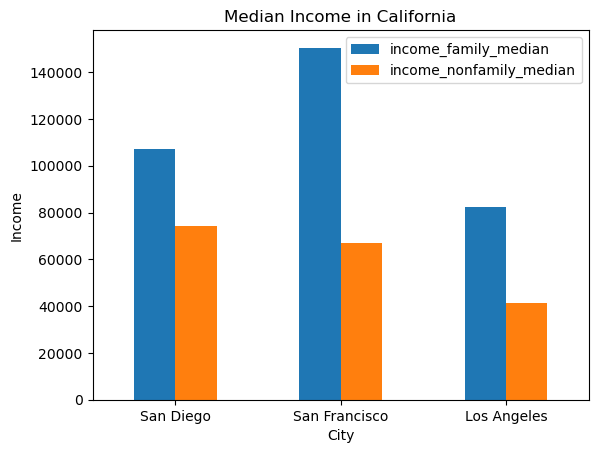

In [11]:
# Median income (household and nonhousehold) for San Diego, San Francisco, and Los Angeles
labels =  ['San Diego', 'San Francisco', 'Los Angeles']
IncomeCA = Top3cities.plot(kind='bar', y=['income_family_median', 'income_nonfamily_median'], stacked=False)
IncomeCA.set_xticklabels(labels)
IncomeCA.legend(loc='upper right')
plt.title('Median Income in California')
plt.xlabel('City')
plt.ylabel('Income')
plt.xticks( rotation=0, ha='center')
plt.savefig("final_figures/fig10_income_top_cities.png", bbox_inches="tight")

#### Fig11: Median income (household and nonhousehold) for Jackson, Hattiesburg, and Gulfport

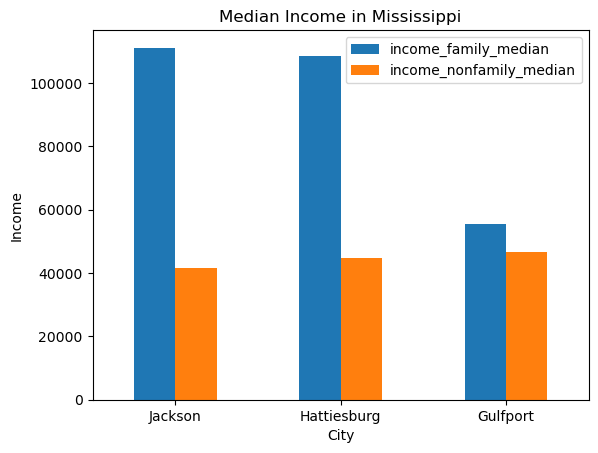

In [12]:
# Median income (household and nonhousehold) for Jackson, Hattiesburg, and Gulfport
labels =  ['Jackson', 'Hattiesburg', 'Gulfport']
IncomeMS = Tail3cities.plot(kind='bar', y=['income_family_median', 'income_nonfamily_median'], stacked=False)
IncomeMS.set_xticklabels(labels)
IncomeMS.legend(loc='upper right')
plt.title('Median Income in Mississippi')
plt.xlabel('City')
plt.ylabel('Income')
plt.xticks( rotation=0, ha='center')
plt.savefig("final_figures/fig11_income_tail_cities.png", bbox_inches="tight")

#### Fig12: Total population and gender distribution for three CA cities

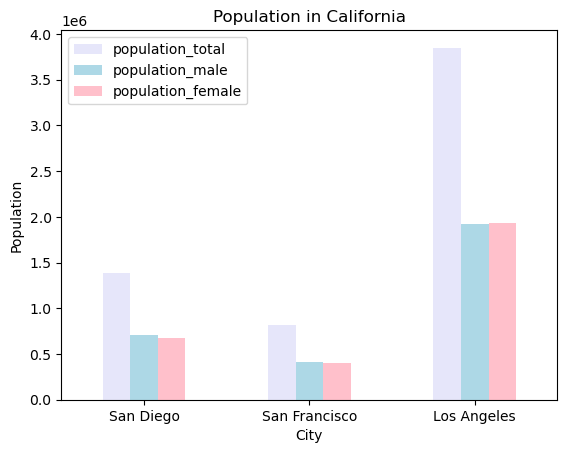

In [13]:
# Total population and gender distribution for three CA cities
labels =  ['San Diego', 'San Francisco', 'Los Angeles']
colors = ['#E6E6FA', '#ADD8E6', 'pink']
PopulationCA= Top3cities.plot(kind='bar', y=['population_total', 'population_male', 'population_female'], color=colors, stacked=False)
PopulationCA.set_xticklabels(labels)
plt.title('Population in California')
plt.xlabel('City')
plt.ylabel('Population')
plt.xticks(rotation=0, ha='center')
plt.savefig("final_figures/fig12_population_top_cities.png", bbox_inches="tight")

#### Fig13: Total population and gender distribution for three MS cities

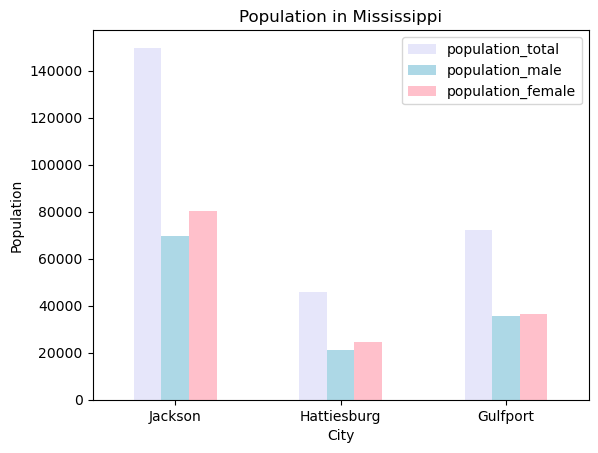

In [14]:
# Total population and gender distribution for three MS cities
labels =  ['Jackson', 'Hattiesburg', 'Gulfport']
colors = ['#E6E6FA', '#ADD8E6', 'pink']
PopulationMS= Tail3cities.plot(kind='bar', y=['population_total', 'population_male', 'population_female'], color=colors, stacked=False)
PopulationMS.set_xticklabels(labels)
plt.title('Population in Mississippi')
plt.xlabel('City')
plt.ylabel('Population')
plt.xticks(rotation=0, ha='center')
plt.savefig("final_figures/fig13_population_tail_cities.png", bbox_inches="tight")

#### Fig14: Median age, female and male for three CA cities

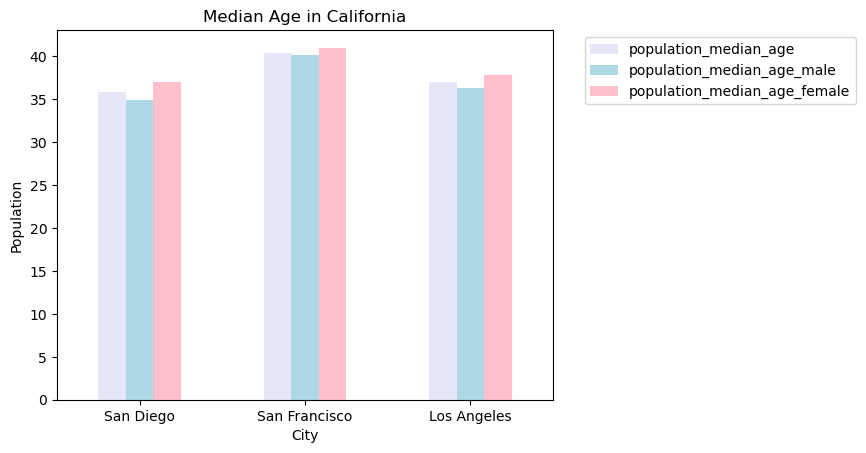

In [15]:
# Median age, female and male for three CA cities
labels =  ['San Diego', 'San Francisco', 'Los Angeles']
colors = ['#E6E6FA', '#ADD8E6', 'pink']
AgeCA= Top3cities.plot(kind='bar', y=['population_median_age', 'population_median_age_male', 'population_median_age_female'], color=colors, stacked=False)
AgeCA.set_xticklabels(labels)
AgeCA.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Median Age in California')
plt.xlabel('City')
plt.ylabel('Population')
plt.xticks(rotation=0, ha='center')
plt.savefig("final_figures/fig14_age_top_cities.png", bbox_inches="tight")

#### Fig15: Median age, female and male for three MS cities

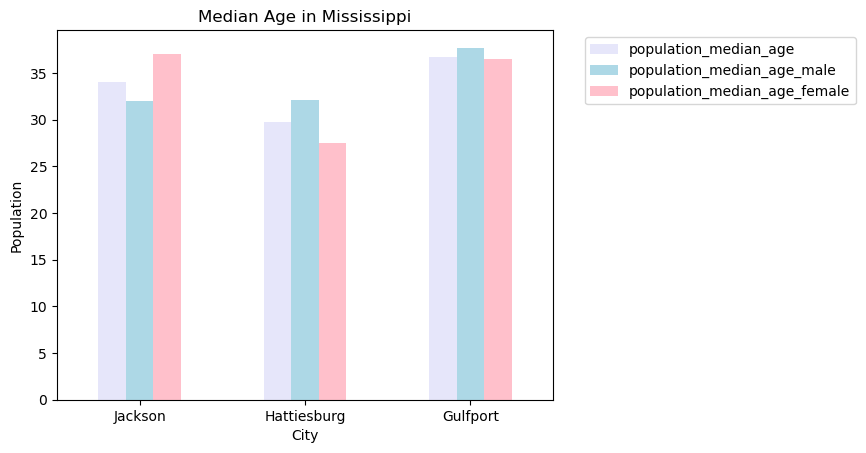

In [16]:
# Median age, female and male for three MS cities
labels =  ['Jackson', 'Hattiesburg', 'Gulfport']
colors = ['#E6E6FA', '#ADD8E6', 'pink']
AgeMS= Tail3cities.plot(kind='bar', y=['population_median_age', 'population_median_age_male', 'population_median_age_female'], color=colors, stacked=False)
AgeMS.set_xticklabels(labels)
AgeMS.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Median Age in Mississippi')
plt.xlabel('City')
plt.ylabel('Population')
plt.xticks(rotation=0, ha='center')
plt.savefig("final_figures/fig15_age_tail_cities.png", bbox_inches="tight")

Correlate brewery numbers with Demographics

#### Fig16: Any correlation of demographic variables between the locations and quantity of micro/brewpubs 

In [17]:
# Set dataframe to plot
SummaryCorrelation_df = last_df.groupby(['State', 'City'])[['population_total','population_male',  'population_female', 'population_median_age',
       'population_median_age_male', 'population_median_age_female','income_household', 'income_household_median','income_family_median','income_nonfamily_median']].mean()
SummaryCorrelation_df


population_total  population_male  population_female   
State   City                                                                 
Alabama Alabaster              33670.0          16058.0            17612.0  \
        Anniston               21545.0           9639.0            11906.0   
        Birmingham            196410.0          94696.0           101714.0   
        Decatur                57754.0          28253.0            29501.0   
        Dothan                 71283.0          33706.0            37577.0   
...                                ...              ...                ...   
Wyoming Cheyenne               65048.0          31310.0            33738.0   
        Gillette               33061.0          17614.0            15447.0   
        Laramie                28531.0          14477.0            14054.0   
        Rock Springs           20787.0          10991.0             9796.0   
        Sheridan               20724.0           9987.0            10737.0   

                      population_median_age  population_median_age_male   
State   City                                                              
Alabama Alabaster                      42.0                        42.4  \
        Anniston                       42.4                        41.8   
        Birmingham                     37.2                        32.9   
        Decatur                        42.1                        42.1   
        Dothan                         40.5                        38.9   
...                                     ...                         ...   
Wyoming Cheyenne                       39.3                        39.7   
        Gillette                       36.0                        36.2   
        Laramie                        28.3                        29.3   
        Rock Springs                   37.4                        37.3   
        Sheridan                       38.6                        39.8   

                      population_median_age_female  income_household   
State   City                                                           
Alabama Alabaster                             40.7           12331.0  \
        Anniston                              43.1            8623.0   
        Birmingham                            40.1           87570.0   
        Decatur                               42.1           23729.0   
        Dothan                                42.2           30301.0   
...                                            ...               ...   
Wyoming Cheyenne                              38.4            8473.0   
        Gillette                              35.3           13103.0   
        Laramie                               27.0           61688.0   
        Rock Springs                          37.6           29970.0   
        Sheridan                              38.3           54012.0   

                      income_household_median  income_family_median   
State   City                                                          
Alabama Alabaster                     85144.0               96181.0  \
        Anniston                      39034.0               64544.0   
        Birmingham                    36614.0               45763.0   
        Decatur                       52013.0               70450.0   
        Dothan                        45088.0               56812.0   
...                                       ...                   ...   
Wyoming Cheyenne                      44262.0              111556.0   
        Gillette                      63700.0               26743.0   
        Laramie                       56452.0               32974.0   
        Rock Springs                  18777.0               23387.0   
        Sheridan                      26540.0               36185.0   

                      income_nonfamily_median  
State   City                                   
Alabama Alabaster                     24436.0  
        Anniston          

In [18]:
# Select Demographics for top 3 and tail 3
SummaryDemo = SummaryCorrelation_df.loc[['California', 'Mississippi'],['San Diego', 'San Francisco', 'Los Angeles', 'Jackson', 'Hattiesburg', 'Gulfport'],:]
SummaryDemo

population_total  population_male   
State       City                                               
California  San Diego             1381600.0         707804.0  \
            San Francisco          815201.0         417313.0   
            Los Angeles           3849306.0        1920499.0   
Mississippi Jackson                149813.0          69597.0   
            Hattiesburg             45704.0          21170.0   
            Gulfport                72096.0          35421.0   

                           population_female  population_median_age   
State       City                                                      
California  San Diego               673796.0                   35.9  \
            San Francisco           397888.0                   40.4   
            Los Angeles            1928807.0                   37.0   
Mississippi Jackson                  80216.0                   34.0   
            Hattiesburg              24534.0                   29.7   
            Gulfport                 36675.0                   36.7   

                           population_median_age_male   
State       City                                        
California  San Diego                            34.9  \
            San Francisco                        40.1   
            Los Angeles                          36.3   
Mississippi Jackson                              32.0   
            Hattiesburg                          32.1   
            Gulfport                             37.7   

                           population_median_age_female  income_household   
State       City                                                            
California  San Diego                              37.0           11759.0  \
            San Francisco                          41.0           13112.0   
            Los Angeles                            37.8           13574.0   
Mississippi Jackson                                37.0           14159.0   
            Hattiesburg                            27.5           10513.0   
            Gulfport                               36.5            7979.0   

                           income_household_median  income_family_median   
State       City                                                           
California  San Diego                      93042.0              107093.0  \
            San Francisco                 121826.0              150429.0   
            Los Angeles                    70372.0               82317.0   
Mississippi Jackson                        35070.0              111133.0   
            Hattiesburg                    40080.0              108605.0   
            Gulfport                       43066.0               55430.0   

                           income_nonfamily_median  
State       City                                    
California  San Diego                      74377.0  
            San Francisco                  66875.0  
            Los Angeles                    41376.0  
Mississippi Jackson                        41723.0  
            Hattiesburg                    44707.0  
            Gulfport                       46603.0

In [19]:
# Select breweries for top 3 and tail 3
SummaryBrew_df = last_df.groupby(['State', 'City'])[['brewery_type']].value_counts()
SummaryBrew_df

State    City          brewery_type
Alabama  Alabaster     planning        1
         Anniston      brewpub         1
         Birmingham    micro           6
                       planning        2
         Decatur       micro           1
                                      ..
Wyoming  Laramie       micro           1
         Rock Springs  micro           1
                       brewpub         1
         Sheridan      micro           2
                       planning        1
Name: count, Length: 2046, dtype: int64

In [20]:
# Filter for micro and brewpub only
SummaryBrewCorrelation = SummaryBrew_df.loc[['California', 'Mississippi'],['San Diego', 'San Francisco', 'Los Angeles', 'Jackson', 'Hattiesburg', 'Gulfport'],['micro', 'brewpub']]
SummaryBrewCorrelation

State        City           brewery_type
California   San Diego      micro           45
                            brewpub         22
             San Francisco  micro           15
                            brewpub         17
             Los Angeles    micro           18
                            brewpub          7
Mississippi  Jackson        micro            1
             Hattiesburg    micro            1
             Gulfport       micro            1
Name: count, dtype: int64

In [21]:
SummaryBrewCorrelation.unstack()

brewery_type               micro  brewpub
State       City                         
California  San Diego       45.0     22.0
            San Francisco   15.0     17.0
            Los Angeles     18.0      7.0
Mississippi Jackson          1.0      NaN
            Hattiesburg      1.0      NaN
            Gulfport         1.0      NaN

In [22]:
microlast = SummaryBrewCorrelation.loc[:,:,'micro']
microlast

State        City         
California   San Diego        45
             San Francisco    15
             Los Angeles      18
Mississippi  Jackson           1
             Hattiesburg       1
             Gulfport          1
Name: count, dtype: int64

In [23]:
# Merge variables to plot into the same dataframe
merged_correlation_df = pd.merge(microlast, SummaryDemo, on='City', how='inner')
merged_correlation_df

,count,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,income_household,income_household_median,income_family_median,income_nonfamily_median
City,,,,,,,,,,,
San Diego,45,1381600.0,707804.0,673796.0,35.9,34.9,37.0,11759.0,93042.0,107093.0,74377.0
San Francisco,15,815201.0,417313.0,397888.0,40.4,40.1,41.0,13112.0,121826.0,150429.0,66875.0
Los Angeles,18,3849306.0,1920499.0,1928807.0,37.0,36.3,37.8,13574.0,70372.0,82317.0,41376.0
Jackson,1,149813.0,69597.0,80216.0,34.0,32.0,37.0,14159.0,35070.0,111133.0,41723.0
Hattiesburg,1,45704.0,21170.0,24534.0,29.7,32.1,27.5,10513.0,40080.0,108605.0,44707.0
Gulfport,1,72096.0,35421.0,36675.0,36.7,37.7,36.5,7979.0,43066.0,55430.0,46603.0


The r-squared is: 0.2156795587460017


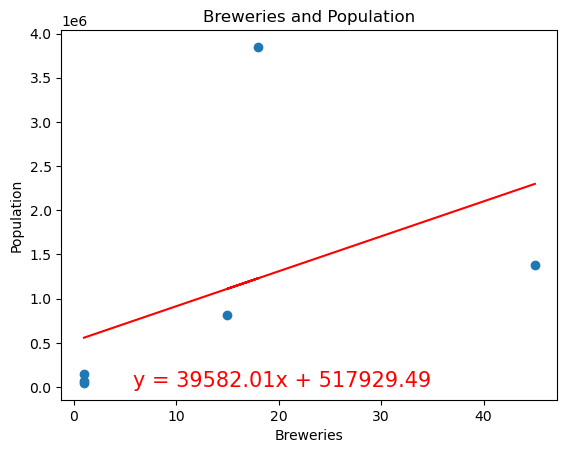

In [26]:
# Plot Breweries (micro) vs Population
x_values = merged_correlation_df.iloc[:,0]
y_values = merged_correlation_df.iloc[:,1]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.title('Breweries and Population')
plt.xlabel('Breweries')
plt.ylabel('Population')
print(f"The r-squared is: {rvalue**2}")
plt.savefig("final_figures/fig16_Breweries_vs_Population.png", bbox_inches="tight")
plt.show()


The r-squared is: 0.04676921516224392


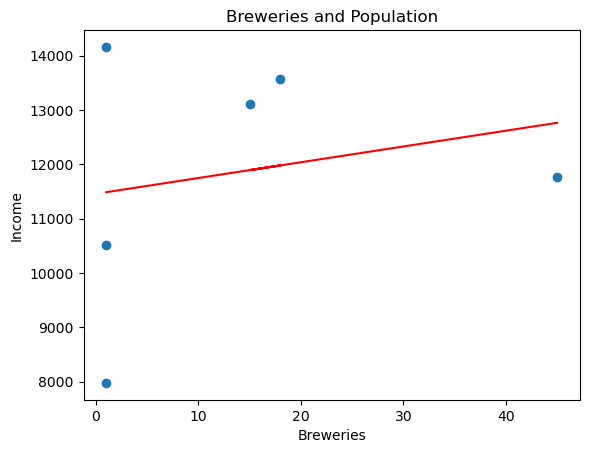

In [25]:
# Plot Breweries (micro) vs Income
x_values = merged_correlation_df.iloc[:,0]
y_values = merged_correlation_df.iloc[:,7]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.title('Breweries and Population')
plt.xlabel('Breweries')
plt.ylabel('Income')
print(f"The r-squared is: {rvalue**2}")
plt.savefig("final_figures/fig17_Breweries_vs_Income.png", bbox_inches="tight")
plt.show()


### Conclusions, if any; how do the dems compare? Could we find a place with similar dems as the city(s) with high concentrations of micro/brewpubs and yet the market isn't saturated? (perfect for Stoutistical Analysis ;)